# Проект "Телеком"

Оператор связи «ТелеДом» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. 

<b>Описание услуг</b>

Оператор предоставляет два основных типа услуг: 
- 1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- 2. Интернет. Подключение может быть двух типов: через телефонную линию DSL (от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

<b>Описание данных</b>

Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:

- contract — информация о договорах;
- personal — персональные данные клиентов;
- internet — информация об интернет-услугах;
- phone — информация об услугах телефонии.

Таблица telecom.contract

- customerID — ID абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Таблица personal

- customerID — ID пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Таблица telecom.internet

- customerID — ID пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Таблица telecom.phone

- customerID — ID пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Информация о договорах актуальна на 1 февраля 2020.

## Описание хода работы

Шаг 1. Загрузить данные

Подключиться к базе данных, используя данные для входа.

Шаг 2. Провести исследовательский анализ и предобработку данных

1. Проанализировать исходные данные. Проверить:
    - Все ли таблицы содержат данные.
    - Соответствует ли количество таблиц условию задачи.
2. Выделить среди клиентов группы действующих и недействующих. Сравить их поведение
3. Выделить признаки для обучения модели
    
Шаг 3. Обучить модель

1. Рассмотреть классы моделей:
    - решающее дерево или случайный лес,
    - бустинги,
    - нейронные сети.
2. Найти лучшую модель для прогноза оттока клиентов. Оцените её качество метрикой ROC-AUC. Выберите лучшую модель по значению метрики на кросс-валидации.
3. Подобрать значения как минимум двум гиперпараметрам хотя бы для одной модели. Лучше всего использовать методы автоматизированного подбора гиперпараметров: GridSearchCV, RandomizedSearchCV, OptunaSearchCV, Optuna и другие.

Шаг 4. Протестируйте модель и продемонстрируйте её работу

1. Проверьте качество лучшей модели на тестовой выборке. Значение метрики ROC-AUC должно быть не менее 0.85. Для интерпретируемости модели дополнительно выведите значение accuracy.
2. Постройте матрицу ошибок лучшей модели. Отобразите полноту и точность модели на графике.
3. Проанализируйте важность основных входных признаков, влияющих на отток клиентов.
4. Для одного из важных входных признаков проведите дополнительное исследование:
5. Покажите график зависимости входного и целевого признаков.

Шаг 5. Сделайте общий вывод по работе

Напишите общие выводы, предложите способы для дальнейшего улучшения модели и дайте бизнес-рекомендации заказчику.

## Настройки рабочей тетради

In [1]:
# Импорт библиотек

from sqlalchemy import create_engine

import pandas as pd

import matplotlib.pyplot as plt
import datetime as dt

from math import ceil
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import mean_squared_error
from math import sqrt
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.classifier import NeuralNetClassifier
from skorch.dataset import ValidSplit
from sklearn.metrics import make_scorer

from sklearn.metrics import confusion_matrix
import seaborn as sns

import os

In [2]:
# Настройки библиотек

pd.options.mode.chained_assignment = None  # default='warn'
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

## Загрузка данных

In [4]:
engine = create_engine(connection_string) 

In [5]:
query = '''
SELECT
    *
FROM telecom.contract
'''

contract = pd.read_sql_query(query, con=engine) 
display(contract)
contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,Two year,Yes,Bank transfer (automatic),21.15,1419.40
7039,6840-RESVB,2019-02-26,None,One year,Yes,Mailed check,84.80,1990.50
7040,2234-XADUH,2019-09-02,None,One year,Yes,Credit card (automatic),103.20,7362.90
7041,4801-JZAZL,2019-06-26,None,Month-to-month,Yes,Electronic check,29.60,346.45


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [6]:
query = '''
SELECT
    *
FROM telecom.personal
'''

personal = pd.read_sql_query(query, con=engine) 
display(personal)
personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [7]:
query = '''
SELECT
    *
FROM telecom.internet
'''

internet = pd.read_sql_query(query, con=engine) 
display(internet)
internet.info()

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
...,...,...,...,...,...,...,...,...
5513,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5514,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5515,4801-JZAZL,DSL,Yes,No,No,No,No,No
5516,8361-LTMKD,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB


In [8]:
internet.columns = internet.loc[0, :]
internet = internet.drop(0, axis=0)
internet = internet.reset_index(drop=True)

In [9]:
query = '''
SELECT
    *
FROM telecom.phone
'''

phone = pd.read_sql_query(query, con=engine) 
display(phone)
phone.info()

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
...,...,...
6357,2569-WGERO,No
6358,6840-RESVB,Yes
6359,2234-XADUH,Yes
6360,8361-LTMKD,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [10]:
phone.columns = phone.loc[0, :]
phone = phone.drop(0, axis=0)
phone = phone.reset_index(drop=True)

<b> Вывод </b>

- Данные загружены. Количество таблиц соответствует условию задачи;
- Все таблицы имеют набор данных;
- Имеется общий ключ для связи таблиц - поле CustomerID

## Исследовательский анализ данных

### Выделение групп клиентов

Сравним распределения величин ежемесячных платежей (MonthlyCharges) всех действующих клиентов и тех, кто ушёл:
- Для каждой группы посчитаем статистические показатели: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей. 
- Построим гистограммы распределения.

#### Группа "Действующие клиенты"

In [11]:
query = '''
SELECT
    "MonthlyCharges"
FROM telecom.contract
WHERE contract."EndDate" IS NOT NULL
'''

current_clients = pd.read_sql_query(query, con=engine) 
display(current_clients)

,MonthlyCharges
0,53.85
1,70.70
2,99.65
3,104.80
4,103.70
...,...
1864,59.80
1865,44.20
1866,75.75
1867,102.95


In [12]:
print('Статистические показатели:')

current_clients['MonthlyCharges'].describe()

Статистические показатели:


count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

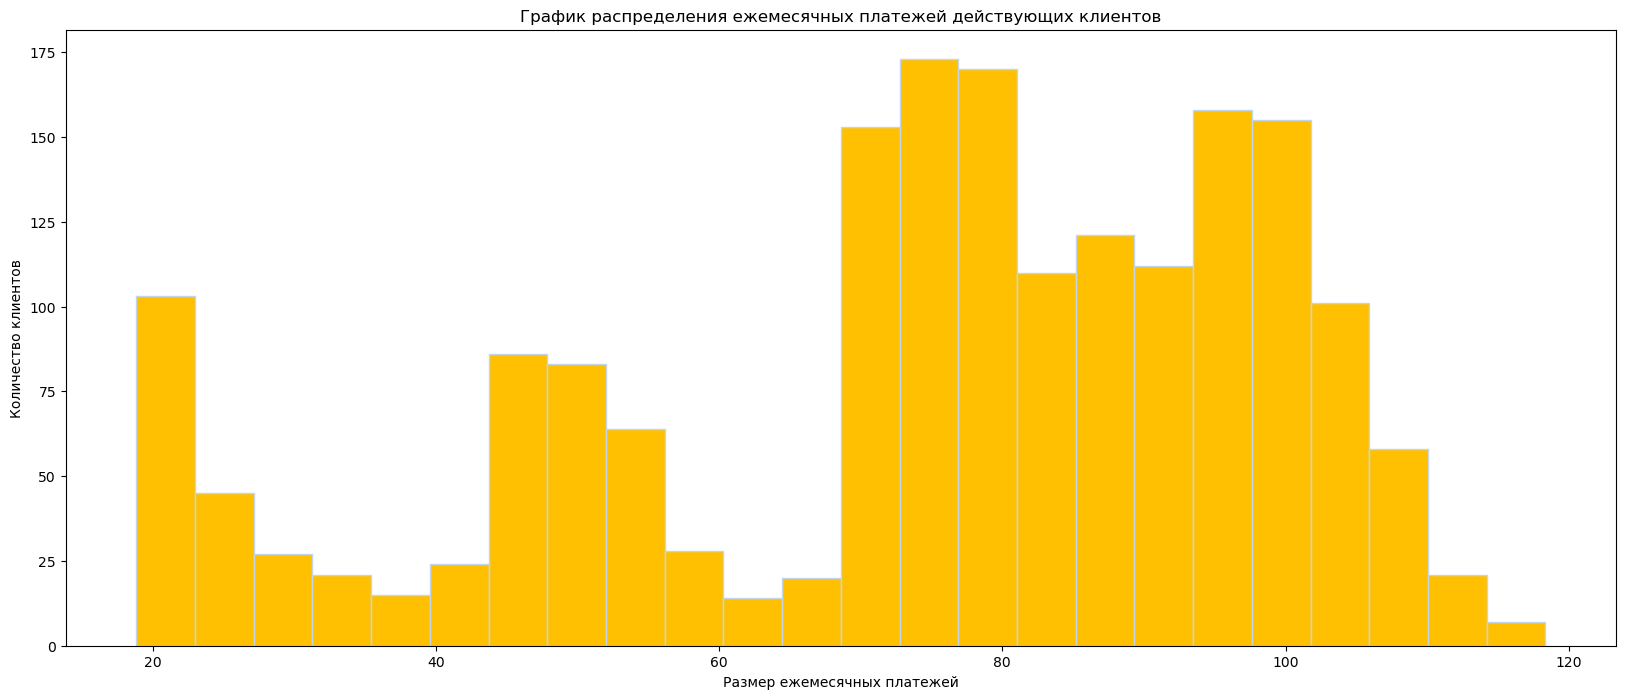

In [13]:
plt.figure(figsize=(20, 8))
plt.hist(current_clients['MonthlyCharges'], color='#ffc001', edgecolor='#c3d5e8', bins=24)
plt.gca().set(title='График распределения ежемесячных платежей действующих клиентов', ylabel='Количество клиентов',  xlabel='Размер ежемесячных платежей')
plt.savefig('current_charges.png')
plt.show()

#### Группа "НЕдействующие клиенты"

In [14]:
query = '''
SELECT
    "MonthlyCharges"
FROM telecom.contract
WHERE contract."EndDate" IS NULL
'''

not_current_clients = pd.read_sql_query(query, con=engine) 
display(not_current_clients)

,MonthlyCharges
0,52.55
1,20.25
2,80.85
3,25.75
4,56.05
...,...
5169,21.15
5170,84.80
5171,103.20
5172,29.60


In [15]:
print('Статистические показатели:')

not_current_clients['MonthlyCharges'].describe()

Статистические показатели:


count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: MonthlyCharges, dtype: float64

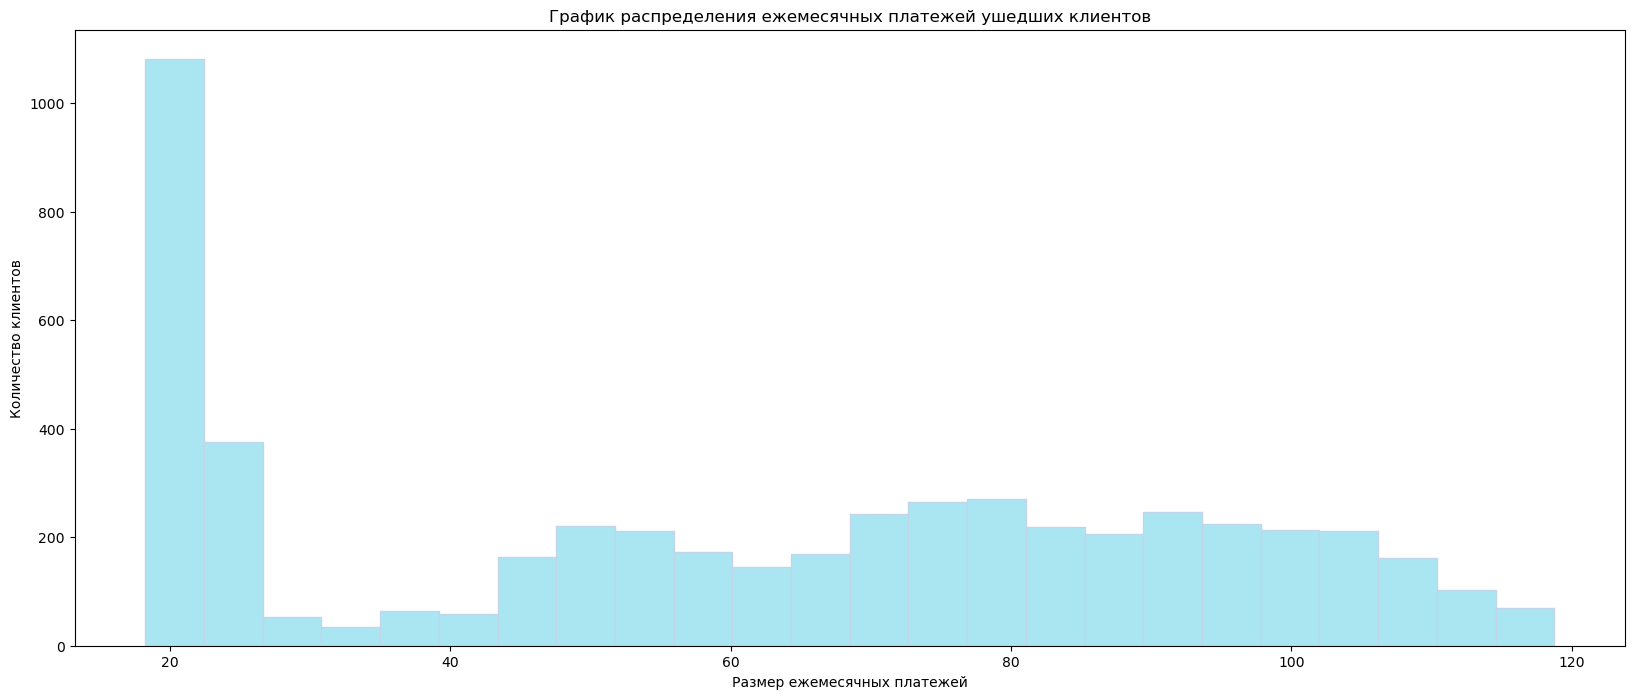

In [16]:
plt.figure(figsize=(20, 8))
plt.hist(not_current_clients['MonthlyCharges'], color='#aae6f2', edgecolor='#c3d5e8', bins=24)
plt.gca().set(title='График распределения ежемесячных платежей ушедших клиентов', ylabel='Количество клиентов', xlabel='Размер ежемесячных платежей')
plt.savefig('not_current_charges.png')

plt.show()

#### Вывод

Среди действующих клиентов намного больше людей тратят больше 70, чем среди ушедших клиентов

### Сравнение поведения клиентов выделенных групп.

Для каждой построим два графика,  отражающие:
  
- долю пользователей телефонной связи,
- долю интернет-пользователей.

In [17]:
query = '''
WITH not_current AS (SELECT
                            'not_current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NOT NULL),

inet_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS internet_count
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet)),
phone_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS phone_count
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.phone))

SELECT 
    not_current.client_type,
    not_current.all_count,
    inet_not_current.internet_count,
    phone_not_current.phone_count
FROM not_current
JOIN inet_not_current ON not_current.client_type=inet_not_current.client_type
JOIN phone_not_current ON not_current.client_type=phone_not_current.client_type
'''

not_current = pd.read_sql_query(query, con=engine) 
display(not_current)

,client_type,all_count,internet_count,phone_count
0,not_current,1869,1756,1699


In [18]:
query = '''
WITH current AS (SELECT
                            'current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NULL),

inet_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS internet_count
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet)),
phone_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS phone_count
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.phone))

SELECT 
    current.client_type,
    current.all_count,
    inet_current.internet_count,
    phone_current.phone_count
FROM current
JOIN inet_current ON current.client_type=inet_current.client_type
JOIN phone_current ON current.client_type=phone_current.client_type
'''

current = pd.read_sql_query(query, con=engine) 
display(current)

,client_type,all_count,internet_count,phone_count
0,current,5174,3761,4662


In [19]:
compare_types = pd.concat([not_current, current])
compare_types = compare_types.reset_index(drop=True)
compare_types['Доля интернет-пользователей'] = compare_types['internet_count']/compare_types['all_count']
compare_types['Доля пользователей телефонной связи'] = compare_types['phone_count']/compare_types['all_count']
display(compare_types)

,client_type,all_count,internet_count,phone_count,Доля интернет-пользователей,Доля пользователей телефонной связи
0,not_current,1869,1756,1699,0.939540,0.909042
1,current,5174,3761,4662,0.726904,0.901044


In [20]:
def compare_graph(df, features_start_at):
    '''Построения графика сравнения двух групп клиентов по заданным в датасете признакам'''
    barWidth1 = 1
    barWidth2 = 0.5
    x_range = list(df.columns)[features_start_at:]

    plt.figure(figsize=(20, 8))

    plt.bar(x_range, df.loc[0, list(df.columns)[features_start_at]:], color='#aae6f2', width=barWidth1/2, edgecolor='#c3d5e8', label='Ушедшие клиенты')
    plt.bar(x_range, df.loc[1, list(df.columns)[features_start_at]:], color='#ffc001', width=barWidth2/2, edgecolor='#c3d5e8', label='Действующие клиенты')

    plt.axhline(y=0, color='gray')
    plt.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.25, -0.3, 0.5, 0.5), prop={'size':25}, ncol = 2)
    plt.ylabel("Значение")
    plt.xlabel("Характеристика")

    plt.rcParams['figure.figsize'] = [25, 7]

    plt.rcParams.update({'font.size': 14})    
    plt.box(False)
    plt.savefig('plt', bbox_inches = "tight")
    plt.show()

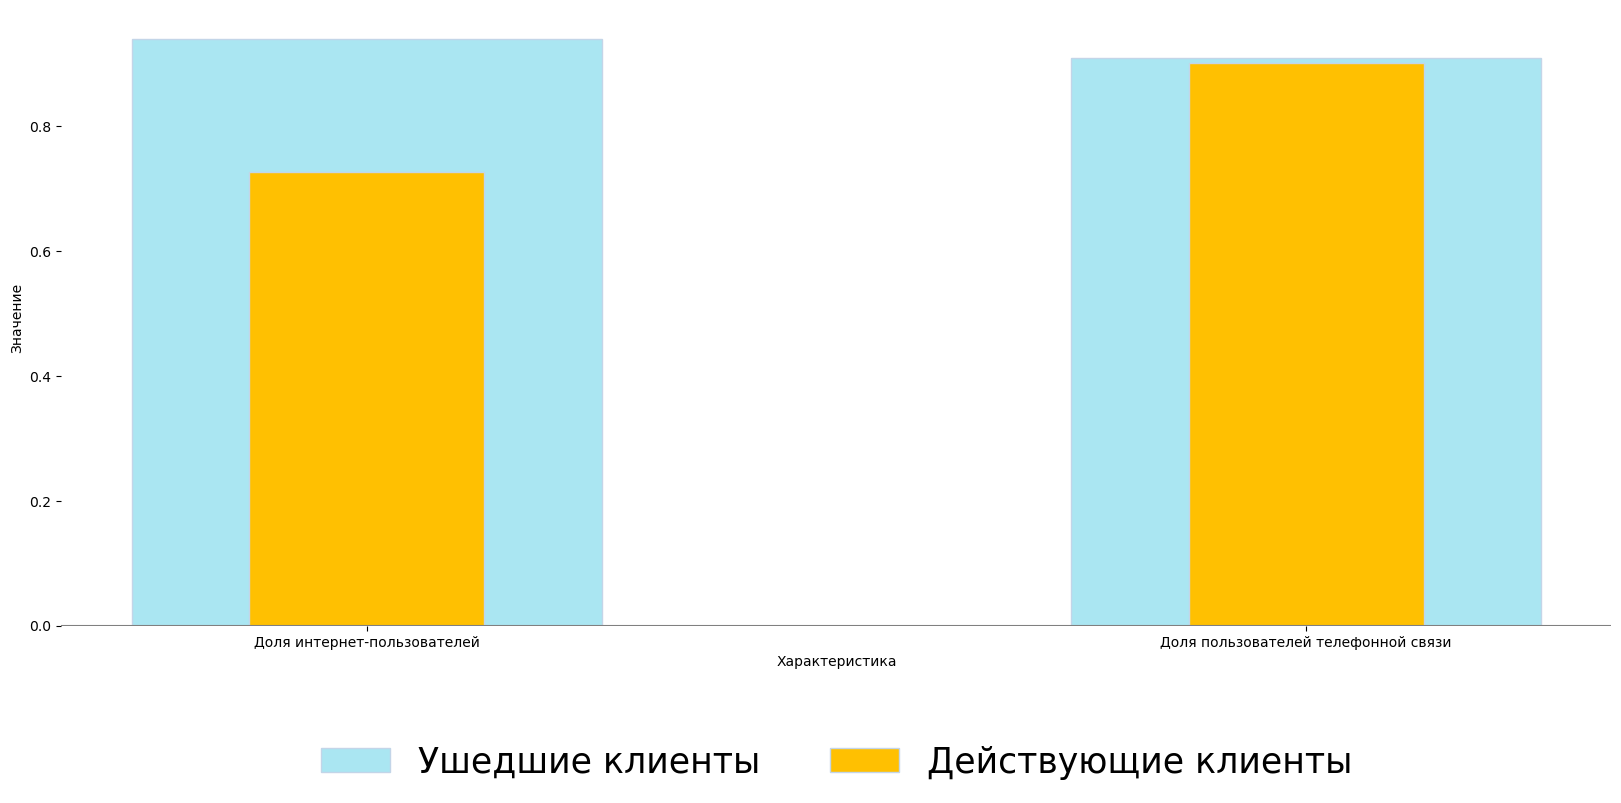

In [21]:
compare_graph(compare_types, 4)

<b>Вывод</b>

- Среди недействующих клиентов гораздо больше интернет-пользователей;
- Доля пользователей телефонной связи у сравнимаемых групп одинаковая

### Выделение признаков для обучения модели

Что точно понятно на данном этапе:
- Поставленная задача - задача классификации. Модель должна предсказывать, уйдет клиент или нет, тогда в качестве целевого признака для обучения выделим из столбца "EndDate" (таблица contract), ушёл клиент или нет (если поле пустое, то это действующий клиент, если нет - клиент ушёл).
- Таблица telecom.phone полностью нам не интересна, т.к. из предыдущего пункта мы узнали, что доля пользователей телефонной связи у групп действующих и недействующих клиентов одинаковая.
- Также из предыдущих пунктов следует, что нам необходимы: признак "расход за месяц" (столбец MonthlyCharges в таблице contract) и является ли клиент пользователем интернет-услуг.
- Не имеет смысла включать в признаки общие расходы вместе с датой начала действия контракта и полным списком использованных услуг, т.к. в сумме это может указывать на то, окончил ли действие договор или нет.
- Признак "дата начала действия договора" является временным, и по-хорошему нужно из него выделить несколько признаков, например: год, месяц, неделя, однако в контексте данной задачи отношения между клиентом и компанией измеряются количеством прошедших месяцев, поэтому нам достаточно посчитать, сколько месяцев прошло с даты начала действия до даты актуализации данных (по условию, это 1 февраля 2020). Таким образом, мы будем рассматривать не в какой год или месяц был заключен договор, а насколько давно он был заключен.

Остальные столбцы таблиц имеет смысл рассмотреть подробнее для решения, включать их в признаки для обучения модели или нет. 

То есть имеем следующий список действий со столбцами:

Таблица contract:
- BeginDate - преобразовать, рассмотреть
- EndDate - выделить целевой признак, рассмотреть
- Type - рассмотреть
- PaperlessBilling - рассмотреть
- PaymentMethod - рассмотреть
- MonthlyCharges - оставить
- TotalCharges - убрать

Таблица personal:
- gender - рассмотреть
- SeniorCitizen - рассмотреть
- Partner - рассмотреть
- Dependents - рассмотреть

Таблица internet:
- выделить признак, является ли пользователем интернет-услуг
- InternetService - рассмотреть
- OnlineSecurity - рассмотреть
- OnlineBackup - рассмотреть
- DeviceProtection - рассмотреть
- TechSupport - рассмотреть
- StreamingTV - рассмотреть
- StreamingMovies - рассмотреть

Таблица phone: не рассматривать

In [22]:
# Выгрузка всех данных в одном датасете

query = '''
SELECT
    *
FROM telecom.contract
FULL JOIN telecom.personal ON contract."customerID"=personal."customerID"
FULL JOIN telecom.internet ON contract."customerID"=internet.c1
'''

data = pd.read_sql_query(query, con=engine) 
data.columns = ['drop1', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 
                'total_charges', 'drop2', 'gender', 'senior_citizen', 'partner','dependents', 'drop3', 'internet_service', 
                'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'] 
data = data.drop(['drop1', 'drop2', 'drop3', 'total_charges'], axis=1)
data = data.drop(7043, axis=0)
display(data)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,Female,0.0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No
1,2020-02-01,None,Two year,No,Mailed check,20.25,Male,0.0,No,Yes,None,None,None,None,None,None,None
2,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,Male,0.0,No,No,DSL,Yes,Yes,No,No,No,No
3,2020-02-01,None,Two year,No,Mailed check,80.85,Female,0.0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes
4,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,Female,0.0,No,No,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2019-01-21,None,Two year,Yes,Bank transfer (automatic),21.15,Female,0.0,No,No,None,None,None,None,None,None,None
7039,2019-02-26,None,One year,Yes,Mailed check,84.80,Male,0.0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes
7040,2019-09-02,None,One year,Yes,Credit card (automatic),103.20,Female,0.0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes
7041,2019-06-26,None,Month-to-month,Yes,Electronic check,29.60,Female,0.0,Yes,Yes,DSL,Yes,No,No,No,No,No


In [23]:
def col_desc(column):
    '''Функция для получения статистического описания признака'''
    print('Описание признака:')
    display(data[column].describe())
    print('-----------------------------------------------------------')
    print('Уникальные значения:')
    display(data[column].value_counts())
    print('-----------------------------------------------------------')
    print('Количество пропусков:', data[column].isna().sum())
    print('-----------------------------------------------------------')

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           1869 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   gender             7043 non-null   object 
 7   senior_citizen     7043 non-null   float64
 8   partner            7043 non-null   object 
 9   dependents         7043 non-null   object 
 10  internet_service   5517 non-null   object 
 11  online_security    5517 non-null   object 
 12  online_backup      5517 non-null   object 
 13  device_protection  5517 non-null   object 
 14  tech_support       5517 non-null   object 
 15  streaming_tv       5517 non-null   object 
 16  streaming_movies   5517 

#### Признак BeginDate

In [25]:
data['begin_date'] = pd.to_datetime(data['begin_date'], format='%Y-%m-%d')
data['EndDate_fillna'] = data['end_date'].fillna('2020-02-01')
data['timedelta'] = (pd.to_datetime(data['EndDate_fillna'], format='%Y-%m-%d') - data['begin_date']).dt.days
data['timedelta']

0         0
1         0
2       479
3         0
4       279
       ... 
7038    376
7039    340
7040    152
7041    220
7042    289
Name: timedelta, Length: 7043, dtype: int64

In [26]:
col_desc('timedelta')

Описание признака:


count    7043.000000
mean      297.378674
std        83.868181
min         0.000000
25%       242.000000
50%       298.000000
75%       351.000000
max       583.000000
Name: timedelta, dtype: float64

-----------------------------------------------------------
Уникальные значения:


304    46
299    44
283    44
292    42
308    42
       ..
55      1
56      1
557     1
550     1
112     1
Name: timedelta, Length: 476, dtype: int64

-----------------------------------------------------------
Количество пропусков: 0
-----------------------------------------------------------


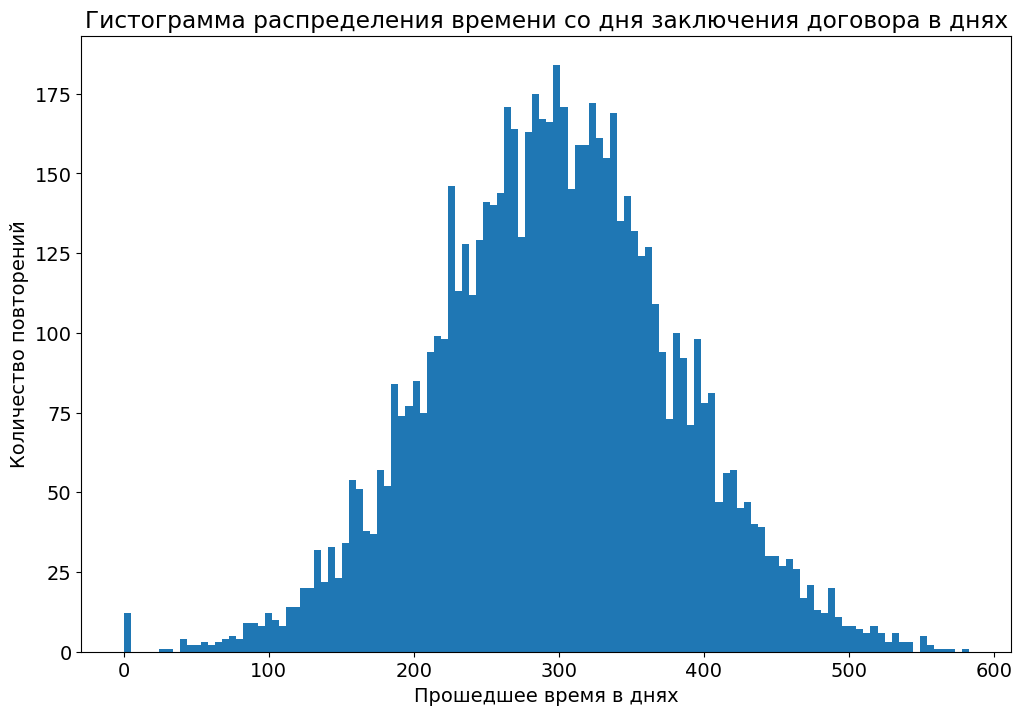

In [27]:
plt.figure(figsize=(12, 8))
plt.hist(data['timedelta'], bins=120)
plt.gca().set(title='Гистограмма распределения времени со дня заключения договора в днях', ylabel='Количество повторений', xlabel='Прошедшее время в днях')
plt.show()

<b>Вывод</b>

Пропусков нет, данные преобразованы, данные имеют нормальное распределение

#### Признак EndDate (целевой)

In [28]:
data['is_not_current'] = data['end_date'].notnull().astype(int)
data['is_not_current']

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    0
7042    0
Name: is_not_current, Length: 7043, dtype: int32

In [29]:
col_desc('is_not_current')

Описание признака:


count    7043.000000
mean        0.265370
std         0.441561
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: is_not_current, dtype: float64

-----------------------------------------------------------
Уникальные значения:


0    5174
1    1869
Name: is_not_current, dtype: int64

-----------------------------------------------------------
Количество пропусков: 0
-----------------------------------------------------------


<b>Вывод</b>

Целевой признак выделен, пропусков нет

#### Признак Type

In [30]:
col_desc('type')

Описание признака:


count               7043
unique                 3
top       Month-to-month
freq                3875
Name: type, dtype: object

-----------------------------------------------------------
Уникальные значения:


Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

-----------------------------------------------------------
Количество пропусков: 0
-----------------------------------------------------------


Подобно тому, как рассматривали использование услуг телефонной связи и интернет-услуг группами клиентов, рассмотрим и этот признак.

In [31]:
query = '''
WITH not_current AS (SELECT
                            'not_current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NOT NULL),

type1_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS month_to_month
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.contract
                                              WHERE "Type" = 'Month-to-month')),
type2_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS two_year_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.contract
                                              WHERE "Type" = 'Two year')),
type3_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS one_year_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.contract
                                              WHERE "Type" = 'One year'))                               

SELECT 
    not_current.client_type,
    not_current.all_count,
    type1_not_current.month_to_month,
    type2_not_current.two_year_type,
    type3_not_current.one_year_type
FROM not_current
JOIN type1_not_current ON not_current.client_type=type1_not_current.client_type
JOIN type2_not_current ON not_current.client_type=type2_not_current.client_type
JOIN type3_not_current ON not_current.client_type=type3_not_current.client_type
'''

not_current = pd.read_sql_query(query, con=engine) 

query = '''
WITH current AS (SELECT
                            'current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NULL),

type1_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS month_to_month
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.contract
                                              WHERE "Type" = 'Month-to-month')),
type2_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS two_year_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.contract
                                              WHERE "Type" = 'Two year')),
type3_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS one_year_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.contract
                                              WHERE "Type" = 'One year'))                                 

SELECT 
    current.client_type,
    current.all_count,
    type1_current.month_to_month,
    type2_current.two_year_type,
    type3_current.one_year_type
FROM current
JOIN type1_current ON current.client_type=type1_current.client_type
JOIN type2_current ON current.client_type=type2_current.client_type
JOIN type3_current ON current.client_type=type3_current.client_type
'''

current = pd.read_sql_query(query, con=engine) 

compare_types = pd.concat([not_current, current])
compare_types = compare_types.reset_index(drop=True)
compare_types['тип оплаты: ежемесячно'] = compare_types['month_to_month']/compare_types['all_count']
compare_types['тип оплаты: раз в год'] = compare_types['one_year_type']/compare_types['all_count']
compare_types['тип оплаты: раз два года'] = compare_types['two_year_type']/compare_types['all_count']

display(compare_types)

,client_type,all_count,month_to_month,two_year_type,one_year_type,тип оплаты: ежемесячно,тип оплаты: раз в год,тип оплаты: раз два года
0,not_current,1869,1655,48,166,0.885500,0.088818,0.025682
1,current,5174,2220,1647,1307,0.429068,0.252609,0.318322


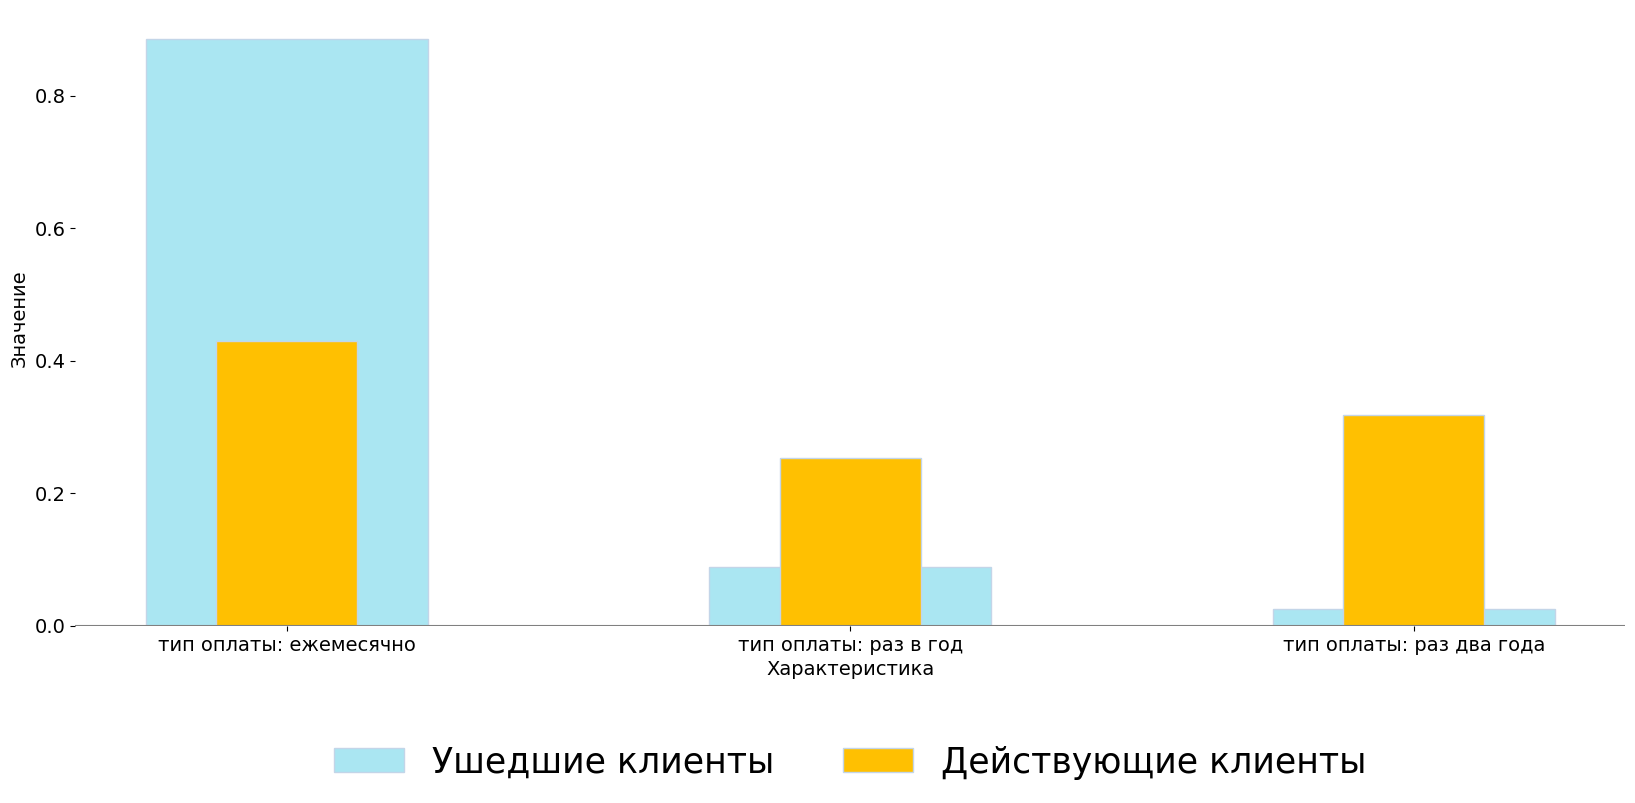

In [32]:
compare_graph(compare_types, 5)

<b>Вывод</b>

Этот столбец стоит включить в признаки для обучения модели, т.к. по нему заметна явна разница среди действующих и уже ушедших клиентах. Пропусков нет.

#### Признак PaperlessBilling

In [33]:
col_desc('paperless_billing')

Описание признака:


count     7043
unique       2
top        Yes
freq      4171
Name: paperless_billing, dtype: object

-----------------------------------------------------------
Уникальные значения:


Yes    4171
No     2872
Name: paperless_billing, dtype: int64

-----------------------------------------------------------
Количество пропусков: 0
-----------------------------------------------------------


In [34]:
query = '''
WITH not_current AS (SELECT
                            'not_current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NOT NULL),

type1_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS yes_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.contract
                                              WHERE "PaperlessBilling" = 'Yes')),
type2_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS no_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.contract
                                             WHERE "PaperlessBilling" = 'No'))                               

SELECT 
    not_current.client_type,
    not_current.all_count,
    type1_not_current.yes_type,
    type2_not_current.no_type
FROM not_current
JOIN type1_not_current ON not_current.client_type=type1_not_current.client_type
JOIN type2_not_current ON not_current.client_type=type2_not_current.client_type
'''

not_current = pd.read_sql_query(query, con=engine) 

query = '''
WITH current AS (SELECT
                            'current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NULL),

type1_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS yes_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.contract
                                              WHERE "PaperlessBilling" = 'Yes')),
type2_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS no_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.contract
                                             WHERE "PaperlessBilling" = 'No'))                              

SELECT 
    current.client_type,
    current.all_count,
    type1_current.yes_type,
    type2_current.no_type
FROM current
JOIN type1_current ON current.client_type=type1_current.client_type
JOIN type2_current ON current.client_type=type2_current.client_type
'''

current = pd.read_sql_query(query, con=engine) 

compare_types = pd.concat([not_current, current])
compare_types = compare_types.reset_index(drop=True)
compare_types['yes_ratio'] = compare_types['yes_type']/compare_types['all_count']
compare_types['no_ratio'] = compare_types['no_type']/compare_types['all_count']
display(compare_types)

,client_type,all_count,yes_type,no_type,yes_ratio,no_ratio
0,not_current,1869,1400,469,0.749064,0.250936
1,current,5174,2771,2403,0.535562,0.464438


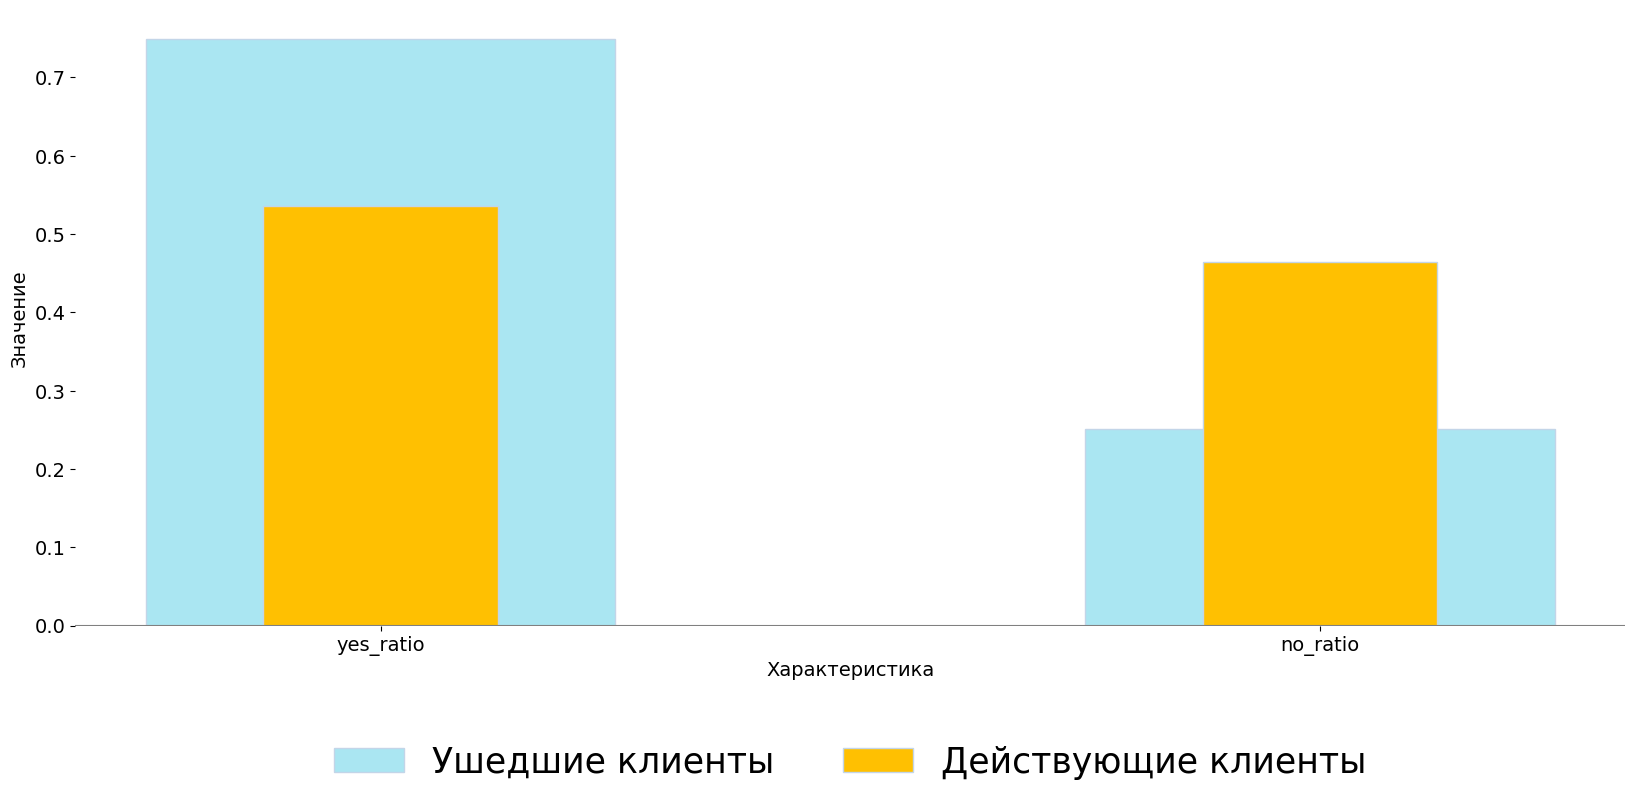

In [35]:
compare_graph(compare_types, 4)

<b>Вывод</b>

Это столбец также стоит включить в признаки для обучения модели, т.к. заметна разница между рассматриваемыми группами клиентов. Пропусков нет.

#### Признак PaymentMethod 

In [36]:
col_desc('payment_method')

Описание признака:


count                 7043
unique                   4
top       Electronic check
freq                  2365
Name: payment_method, dtype: object

-----------------------------------------------------------
Уникальные значения:


Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

-----------------------------------------------------------
Количество пропусков: 0
-----------------------------------------------------------


In [37]:
query = '''
WITH not_current AS (SELECT
                            'not_current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NOT NULL),

type1_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS electronic_check
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.contract
                                              WHERE "PaymentMethod" = 'Electronic check')),
type2_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS mailed_check
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.contract
                                              WHERE "PaymentMethod" = 'Mailed check')),
type3_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS bank
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.contract
                                              WHERE "PaymentMethod" = 'Bank transfer (automatic)')),
type4_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS credit_card
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.contract
                                              WHERE "PaymentMethod" = 'Credit card (automatic)'))  

SELECT 
    not_current.client_type,
    not_current.all_count,
    type1_not_current.electronic_check,
    type2_not_current.mailed_check,
    type3_not_current.bank,
    type4_not_current.credit_card
FROM not_current
JOIN type1_not_current ON not_current.client_type=type1_not_current.client_type
JOIN type2_not_current ON not_current.client_type=type2_not_current.client_type
JOIN type3_not_current ON not_current.client_type=type3_not_current.client_type
JOIN type4_not_current ON not_current.client_type=type4_not_current.client_type

'''

not_current = pd.read_sql_query(query, con=engine) 

query = '''
WITH current AS (SELECT
                            'current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NULL),

type1_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS electronic_check
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.contract
                                              WHERE "PaymentMethod" = 'Electronic check')),
type2_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS mailed_check
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.contract
                                              WHERE "PaymentMethod" = 'Mailed check')),
type3_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS bank
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.contract
                                              WHERE "PaymentMethod" = 'Bank transfer (automatic)')),
type4_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS credit_card
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.contract
                                              WHERE "PaymentMethod" = 'Credit card (automatic)'))  

SELECT 
    current.client_type,
    current.all_count,
    type1_current.electronic_check,
    type2_current.mailed_check,
    type3_current.bank,
    type4_current.credit_card
FROM current
JOIN type1_current ON current.client_type=type1_current.client_type
JOIN type2_current ON current.client_type=type2_current.client_type
JOIN type3_current ON current.client_type=type3_current.client_type
JOIN type4_current ON current.client_type=type4_current.client_type
'''

current = pd.read_sql_query(query, con=engine) 

compare_types = pd.concat([not_current, current])
compare_types = compare_types.reset_index(drop=True)
compare_types['electronic_check_ratio'] = compare_types['electronic_check']/compare_types['all_count']
compare_types['mailed_check_ratio'] = compare_types['mailed_check']/compare_types['all_count']
compare_types['bank_ratio'] = compare_types['bank']/compare_types['all_count']
compare_types['credit_card_ratio'] = compare_types['credit_card']/compare_types['all_count']
display(compare_types)

,client_type,all_count,electronic_check,mailed_check,bank,credit_card,electronic_check_ratio,mailed_check_ratio,bank_ratio,credit_card_ratio
0,not_current,1869,1071,308,258,232,0.573034,0.164794,0.138042,0.124131
1,current,5174,1294,1304,1286,1290,0.250097,0.252029,0.248550,0.249324


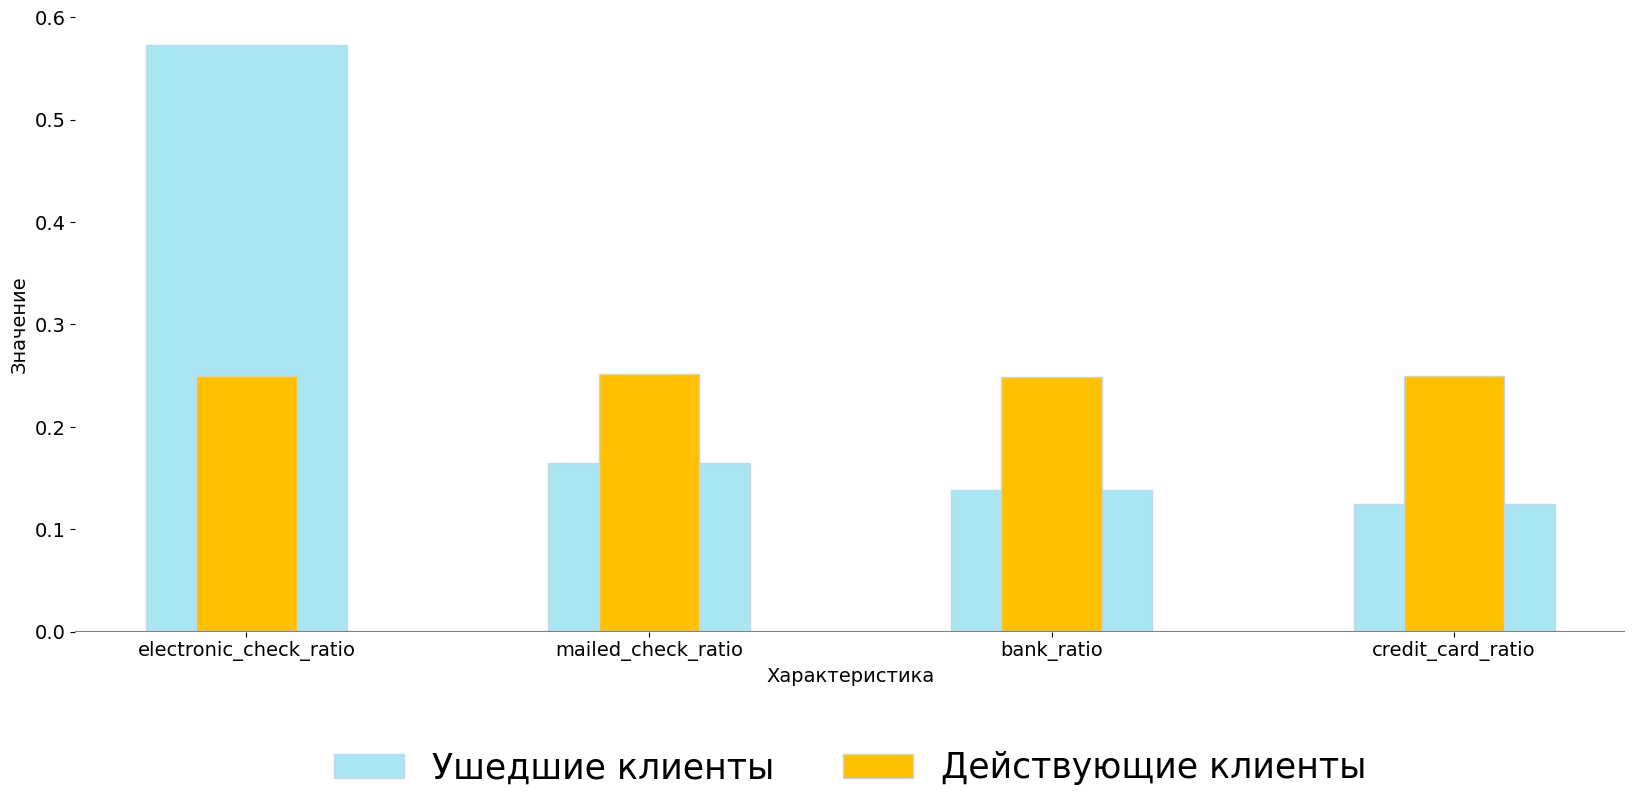

In [38]:
compare_graph(compare_types, 6)

<b> Вывод </b>

Это столбец также стоит включить в признаки для обучения модели, т.к. заметна разница между рассматриваемыми группами клиентов. Пропусков нет.

#### Признак gender

In [39]:
col_desc('gender')

Описание признака:


count     7043
unique       2
top       Male
freq      3555
Name: gender, dtype: object

-----------------------------------------------------------
Уникальные значения:


Male      3555
Female    3488
Name: gender, dtype: int64

-----------------------------------------------------------
Количество пропусков: 0
-----------------------------------------------------------


In [40]:
query = '''
WITH not_current AS (SELECT
                            'not_current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NOT NULL),

type1_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS male_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.personal
                                              WHERE gender = 'Male')),
type2_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS female_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.personal
                                             WHERE gender = 'Female'))                               

SELECT 
    not_current.client_type,
    not_current.all_count,
    type1_not_current.male_type,
    type2_not_current.female_type
FROM not_current
JOIN type1_not_current ON not_current.client_type=type1_not_current.client_type
JOIN type2_not_current ON not_current.client_type=type2_not_current.client_type
'''

not_current = pd.read_sql_query(query, con=engine) 

query = '''
WITH current AS (SELECT
                            'current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NULL),

type1_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS male_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.personal
                                              WHERE gender = 'Male')),
type2_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS female_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.personal
                                             WHERE gender = 'Female'))                              

SELECT 
    current.client_type,
    current.all_count,
    type1_current.male_type,
    type2_current.female_type
FROM current
JOIN type1_current ON current.client_type=type1_current.client_type
JOIN type2_current ON current.client_type=type2_current.client_type
'''

current = pd.read_sql_query(query, con=engine) 

compare_types = pd.concat([not_current, current])
compare_types = compare_types.reset_index(drop=True)
compare_types['male_ratio'] = compare_types['male_type']/compare_types['all_count']
compare_types['female_ratio'] = compare_types['female_type']/compare_types['all_count']
display(compare_types)

,client_type,all_count,male_type,female_type,male_ratio,female_ratio
0,not_current,1869,930,939,0.497592,0.502408
1,current,5174,2625,2549,0.507344,0.492656


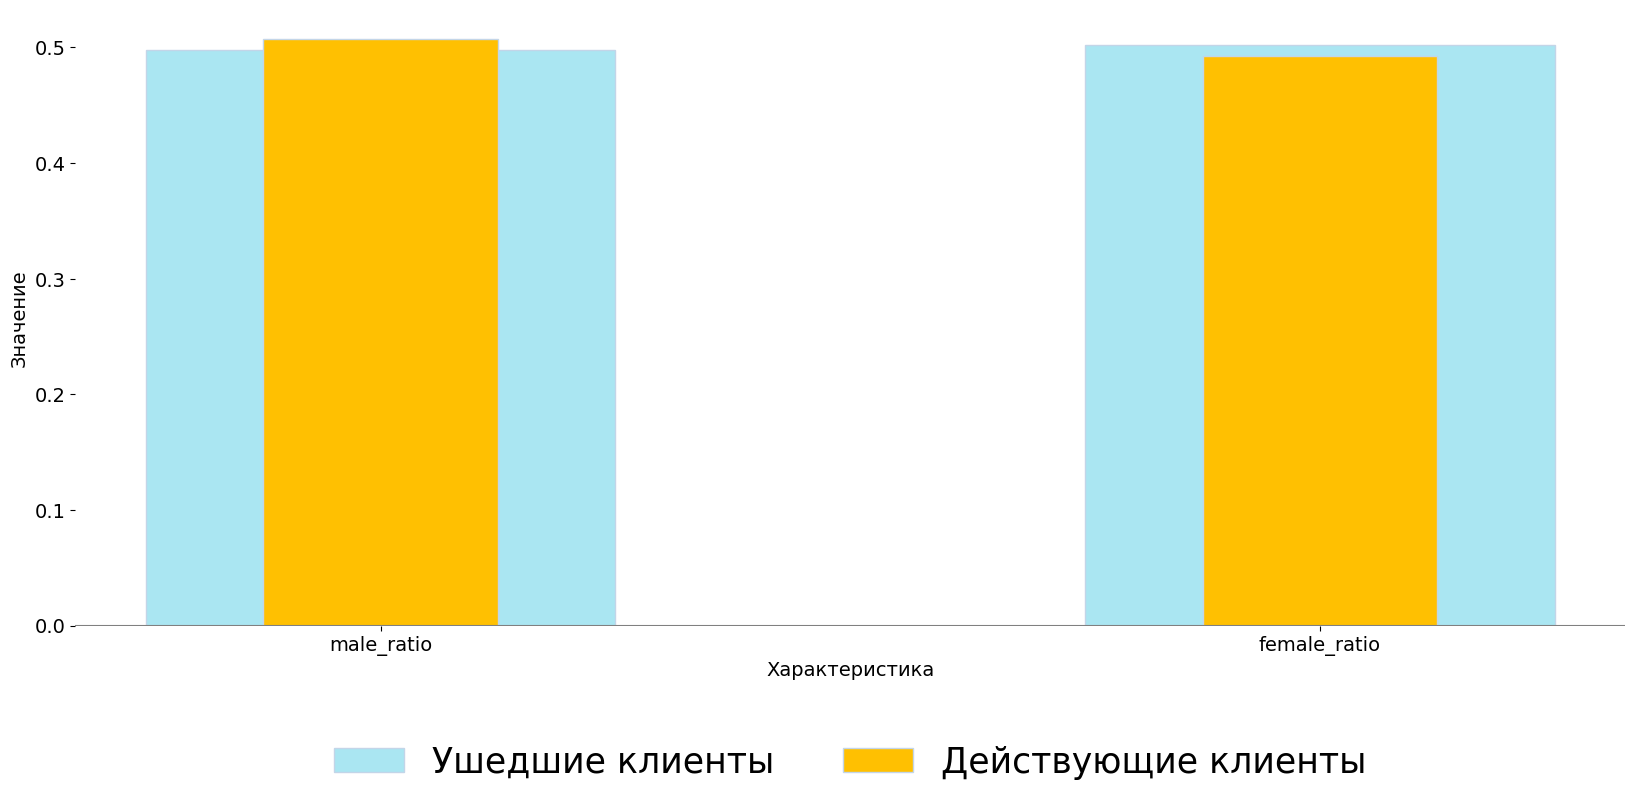

In [41]:
compare_graph(compare_types, 4)

<b>Вывод</b>

Данный столбец не имеет смысла включать в признаки для обучения, т.к. по нему рассматриваемые группы не отличаются

#### Признак SeniorCitizen 

In [42]:
col_desc('senior_citizen')

Описание признака:


count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: senior_citizen, dtype: float64

-----------------------------------------------------------
Уникальные значения:


0.0    5901
1.0    1142
Name: senior_citizen, dtype: int64

-----------------------------------------------------------
Количество пропусков: 0
-----------------------------------------------------------


In [43]:
query = '''
WITH not_current AS (SELECT
                            'not_current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NOT NULL),

type1_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS senior_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.personal
                                              WHERE "SeniorCitizen" = 1)),
type2_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS not_senior_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.personal
                                             WHERE "SeniorCitizen" = 0))                               

SELECT 
    not_current.client_type,
    not_current.all_count,
    type1_not_current.senior_type,
    type2_not_current.not_senior_type
FROM not_current
JOIN type1_not_current ON not_current.client_type=type1_not_current.client_type
JOIN type2_not_current ON not_current.client_type=type2_not_current.client_type
'''

not_current = pd.read_sql_query(query, con=engine) 

query = '''
WITH current AS (SELECT
                            'current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NULL),

type1_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS senior_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.personal
                                              WHERE "SeniorCitizen" = 1)),
type2_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS not_senior_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.personal
                                             WHERE "SeniorCitizen" = 0))                              

SELECT 
    current.client_type,
    current.all_count,
    type1_current.senior_type,
    type2_current.not_senior_type
FROM current
JOIN type1_current ON current.client_type=type1_current.client_type
JOIN type2_current ON current.client_type=type2_current.client_type
'''

current = pd.read_sql_query(query, con=engine) 

compare_types = pd.concat([not_current, current])
compare_types = compare_types.reset_index(drop=True)
compare_types['senior_ratio'] = compare_types['senior_type']/compare_types['all_count']
compare_types['not_senior_ratio'] = compare_types['not_senior_type']/compare_types['all_count']
display(compare_types)

,client_type,all_count,senior_type,not_senior_type,senior_ratio,not_senior_ratio
0,not_current,1869,476,1393,0.254682,0.745318
1,current,5174,666,4508,0.128721,0.871279


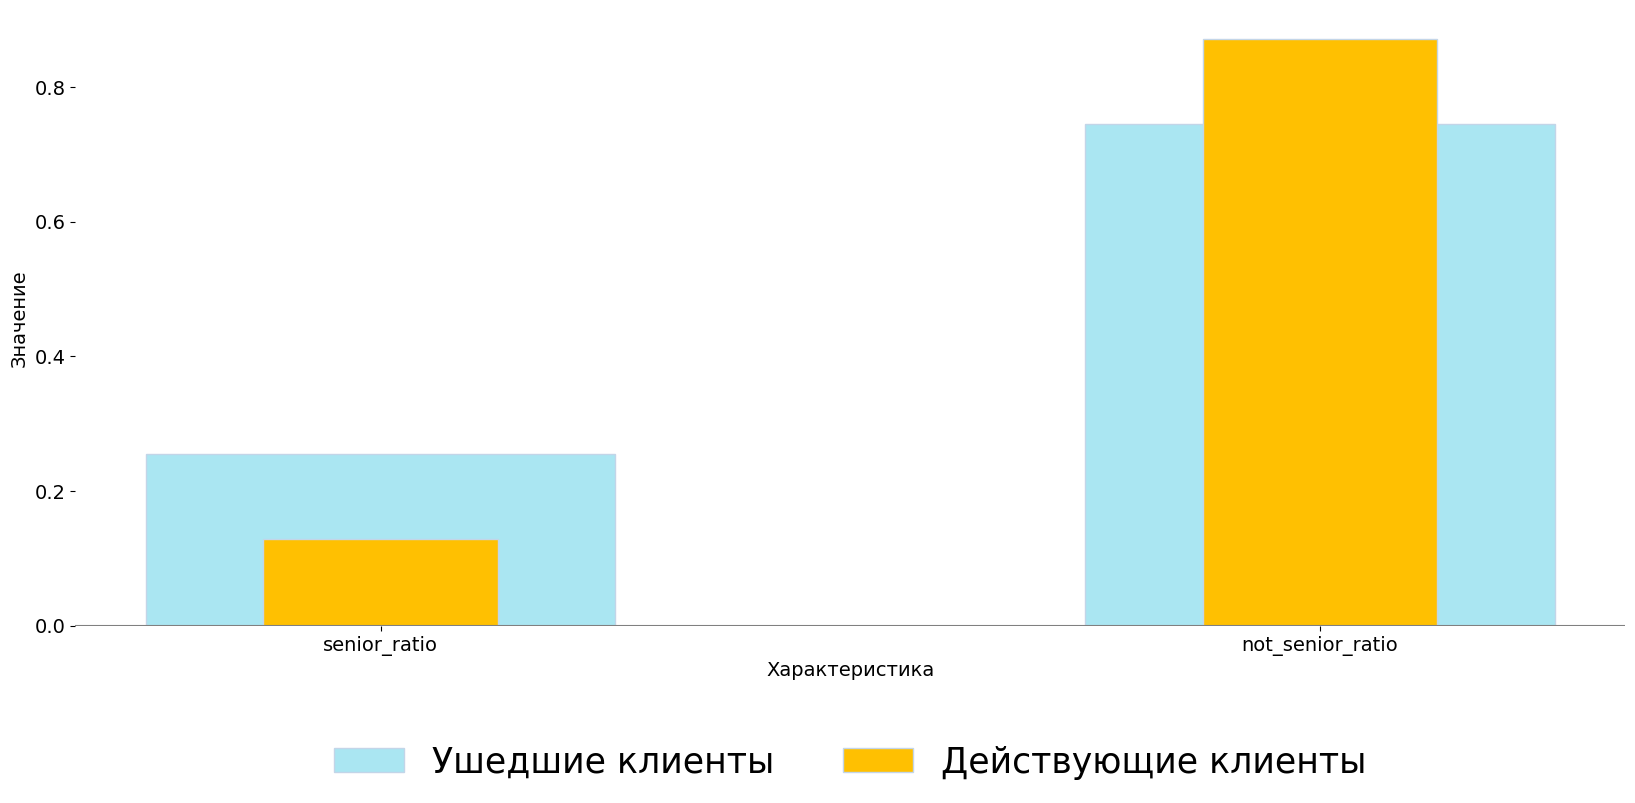

In [44]:
compare_graph(compare_types, 4)

<b>Вывод</b>

Это столбец также стоит включить в признаки для обучения модели, т.к. заметна разница между рассматриваемыми группами клиентов. Пропусков нет.

#### Признак Partner 

In [45]:
col_desc('partner')

Описание признака:


count     7043
unique       2
top         No
freq      3641
Name: partner, dtype: object

-----------------------------------------------------------
Уникальные значения:


No     3641
Yes    3402
Name: partner, dtype: int64

-----------------------------------------------------------
Количество пропусков: 0
-----------------------------------------------------------


In [46]:
query = '''
WITH not_current AS (SELECT
                            'not_current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NOT NULL),

type1_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS yes_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.personal
                                              WHERE "Partner" = 'Yes')),
type2_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS no_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.personal
                                             WHERE "Partner" = 'No'))                               

SELECT 
    not_current.client_type,
    not_current.all_count,
    type1_not_current.yes_type,
    type2_not_current.no_type
FROM not_current
JOIN type1_not_current ON not_current.client_type=type1_not_current.client_type
JOIN type2_not_current ON not_current.client_type=type2_not_current.client_type
'''

not_current = pd.read_sql_query(query, con=engine) 

query = '''
WITH current AS (SELECT
                            'current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NULL),

type1_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS yes_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.personal
                                              WHERE "Partner" = 'Yes')),
type2_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS no_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.personal
                                             WHERE "Partner" = 'No'))                              

SELECT 
    current.client_type,
    current.all_count,
    type1_current.yes_type,
    type2_current.no_type
FROM current
JOIN type1_current ON current.client_type=type1_current.client_type
JOIN type2_current ON current.client_type=type2_current.client_type
'''

current = pd.read_sql_query(query, con=engine) 

compare_types = pd.concat([not_current, current])
compare_types = compare_types.reset_index(drop=True)
compare_types['yes_ratio'] = compare_types['yes_type']/compare_types['all_count']
compare_types['no_ratio'] = compare_types['no_type']/compare_types['all_count']
display(compare_types)

,client_type,all_count,yes_type,no_type,yes_ratio,no_ratio
0,not_current,1869,669,1200,0.357945,0.642055
1,current,5174,2733,2441,0.528218,0.471782


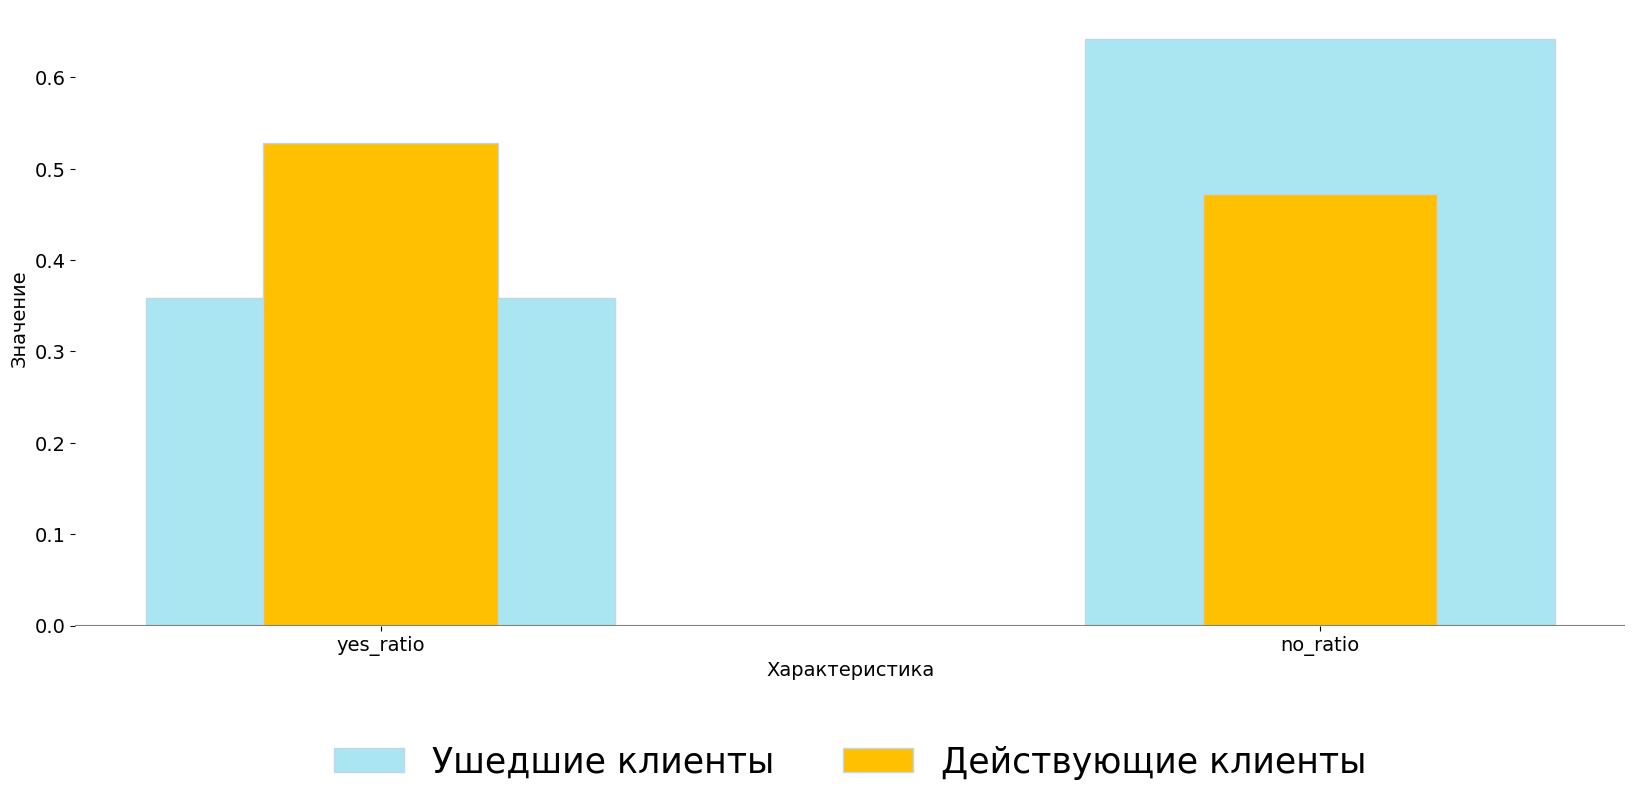

In [47]:
compare_graph(compare_types, 4)

<b>Вывод</b>

Это столбец также стоит включить в признаки для обучения модели, т.к. заметна разница между рассматриваемыми группами клиентов. Пропусков нет.

#### Признак Dependents

In [48]:
col_desc('dependents')

Описание признака:


count     7043
unique       2
top         No
freq      4933
Name: dependents, dtype: object

-----------------------------------------------------------
Уникальные значения:


No     4933
Yes    2110
Name: dependents, dtype: int64

-----------------------------------------------------------
Количество пропусков: 0
-----------------------------------------------------------


In [49]:
query = '''
WITH not_current AS (SELECT
                            'not_current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NOT NULL),

type1_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS yes_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.personal
                                              WHERE "Dependents" = 'Yes')),
type2_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS no_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.personal
                                             WHERE "Dependents" = 'No'))                               

SELECT 
    not_current.client_type,
    not_current.all_count,
    type1_not_current.yes_type,
    type2_not_current.no_type
FROM not_current
JOIN type1_not_current ON not_current.client_type=type1_not_current.client_type
JOIN type2_not_current ON not_current.client_type=type2_not_current.client_type
'''

not_current = pd.read_sql_query(query, con=engine) 

query = '''
WITH current AS (SELECT
                            'current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NULL),

type1_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS yes_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.personal
                                              WHERE "Dependents" = 'Yes')),
type2_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS no_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  "customerID"
                                              FROM telecom.personal
                                             WHERE "Dependents" = 'No'))                              

SELECT 
    current.client_type,
    current.all_count,
    type1_current.yes_type,
    type2_current.no_type
FROM current
JOIN type1_current ON current.client_type=type1_current.client_type
JOIN type2_current ON current.client_type=type2_current.client_type
'''

current = pd.read_sql_query(query, con=engine) 

compare_types = pd.concat([not_current, current])
compare_types = compare_types.reset_index(drop=True)
compare_types['yes_ratio'] = compare_types['yes_type']/compare_types['all_count']
compare_types['no_ratio'] = compare_types['no_type']/compare_types['all_count']
display(compare_types)

,client_type,all_count,yes_type,no_type,yes_ratio,no_ratio
0,not_current,1869,326,1543,0.174425,0.825575
1,current,5174,1784,3390,0.344801,0.655199


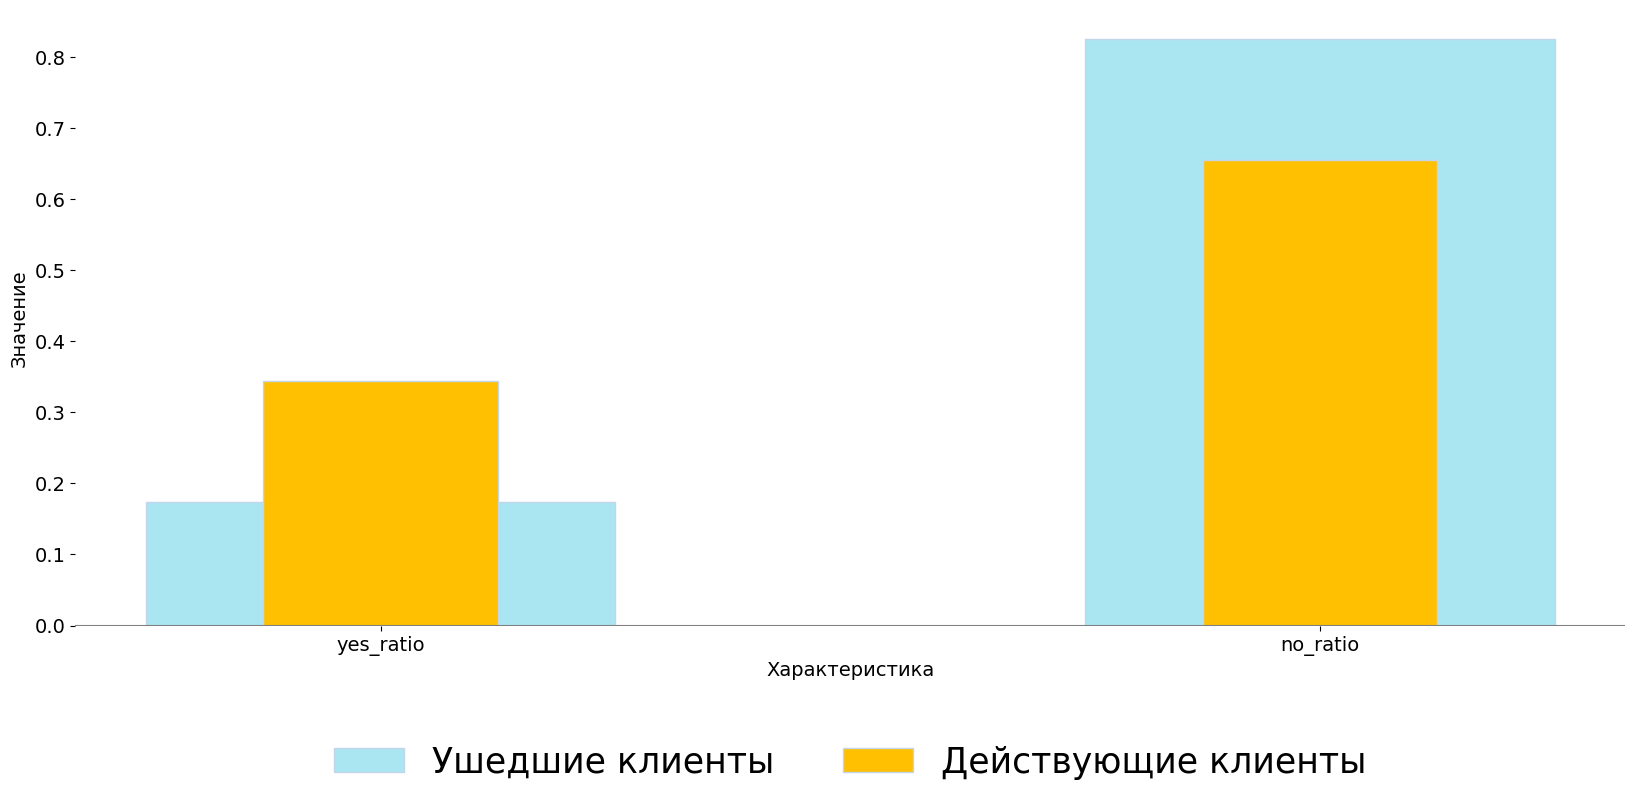

In [50]:
compare_graph(compare_types, 4)

<b>Вывод</b>

Это столбец также стоит включить в признаки для обучения модели, т.к. заметна разница между рассматриваемыми группами клиентов. Пропусков нет.

#### Признак InternetService

In [51]:
col_desc('internet_service')

Описание признака:


count            5517
unique              2
top       Fiber optic
freq             3096
Name: internet_service, dtype: object

-----------------------------------------------------------
Уникальные значения:


Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

-----------------------------------------------------------
Количество пропусков: 1526
-----------------------------------------------------------


В данных присутствуют пропуски - это те клиенты, которые не пользуются интернет услугами. Заполним их соответствующим значением.

In [52]:
data['internet_service'] = data['internet_service'].fillna('not_using_internet')

Распределение среди тех, кто пользуется и не пользуется интернет-услугами вообще мы уже знаем, посмотрим на распределение долей по типу подключения

In [53]:
query = '''
WITH not_current AS (SELECT
                            'not_current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NOT NULL),

type1_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS fiber
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c2 = 'Fiber optic')),
type2_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS dsl
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c2 = 'DSL'))
                         

SELECT 
    not_current.client_type,
    not_current.all_count,
    type1_not_current.fiber,
    type2_not_current.dsl
FROM not_current
JOIN type1_not_current ON not_current.client_type=type1_not_current.client_type
JOIN type2_not_current ON not_current.client_type=type2_not_current.client_type
'''

not_current = pd.read_sql_query(query, con=engine) 

query = '''
WITH current AS (SELECT
                            'current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NULL),

type1_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS fiber
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c2 = 'Fiber optic')),
type2_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS dsl
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c2 = 'DSL'))
                             

SELECT 
    current.client_type,
    current.all_count,
    type1_current.fiber,
    type2_current.dsl
FROM current
JOIN type1_current ON current.client_type=type1_current.client_type
JOIN type2_current ON current.client_type=type2_current.client_type
'''

current = pd.read_sql_query(query, con=engine) 

compare_types = pd.concat([not_current, current])
compare_types = compare_types.reset_index(drop=True)
compare_types['fiber_ratio'] = compare_types['fiber']/compare_types['all_count']
compare_types['dsl_ratio'] = compare_types['dsl']/compare_types['all_count']
display(compare_types)

,client_type,all_count,fiber,dsl,fiber_ratio,dsl_ratio
0,not_current,1869,1297,459,0.693954,0.245586
1,current,5174,1799,1962,0.347700,0.379204


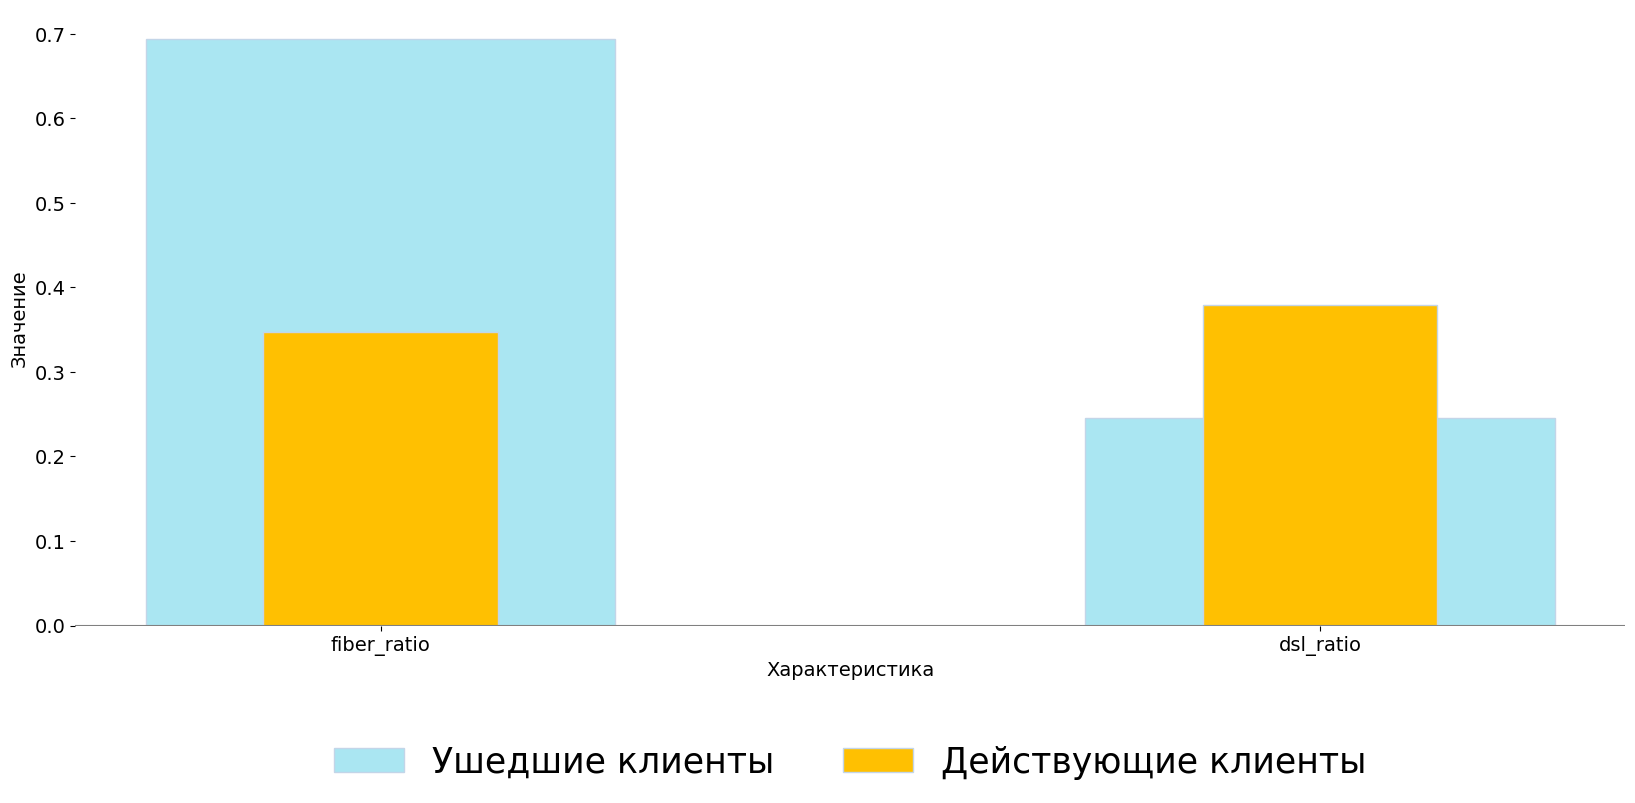

In [54]:
compare_graph(compare_types, 4)

<b>Вывод</b>

Это столбец также стоит включить в признаки для обучения модели, т.к. заметна разница между рассматриваемыми группами клиентов. Пропуски заполнены.

#### Признак OnlineSecurity 

In [55]:
col_desc('online_security')

Описание признака:


count     5517
unique       2
top         No
freq      3498
Name: online_security, dtype: object

-----------------------------------------------------------
Уникальные значения:


No     3498
Yes    2019
Name: online_security, dtype: int64

-----------------------------------------------------------
Количество пропусков: 1526
-----------------------------------------------------------


В данных присутствуют пропуски. Поступим так же, как и с предыдущим признаком.

In [56]:
data['online_security'] = data['online_security'].fillna('not_using_internet')

In [57]:
query = '''
WITH not_current AS (SELECT
                            'not_current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NOT NULL),

type1_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS yes_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c3 = 'Yes')),
type2_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS no_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c3 = 'No'))
                         

SELECT 
    not_current.client_type,
    not_current.all_count,
    type1_not_current.yes_type,
    type2_not_current.no_type
FROM not_current
JOIN type1_not_current ON not_current.client_type=type1_not_current.client_type
JOIN type2_not_current ON not_current.client_type=type2_not_current.client_type
'''

not_current = pd.read_sql_query(query, con=engine) 

query = '''
WITH current AS (SELECT
                            'current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NULL),

type1_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS yes_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c3 = 'Yes')),
type2_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS no_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c3 = 'No'))
                             

SELECT 
    current.client_type,
    current.all_count,
    type1_current.yes_type,
    type2_current.no_type
FROM current
JOIN type1_current ON current.client_type=type1_current.client_type
JOIN type2_current ON current.client_type=type2_current.client_type
'''

current = pd.read_sql_query(query, con=engine) 

compare_types = pd.concat([not_current, current])
compare_types = compare_types.reset_index(drop=True)
compare_types['yes_ratio'] = compare_types['yes_type']/compare_types['all_count']
compare_types['no_ratio'] = compare_types['no_type']/compare_types['all_count']
display(compare_types)

,client_type,all_count,yes_type,no_type,yes_ratio,no_ratio
0,not_current,1869,295,1461,0.157838,0.781701
1,current,5174,1724,2037,0.333204,0.393699


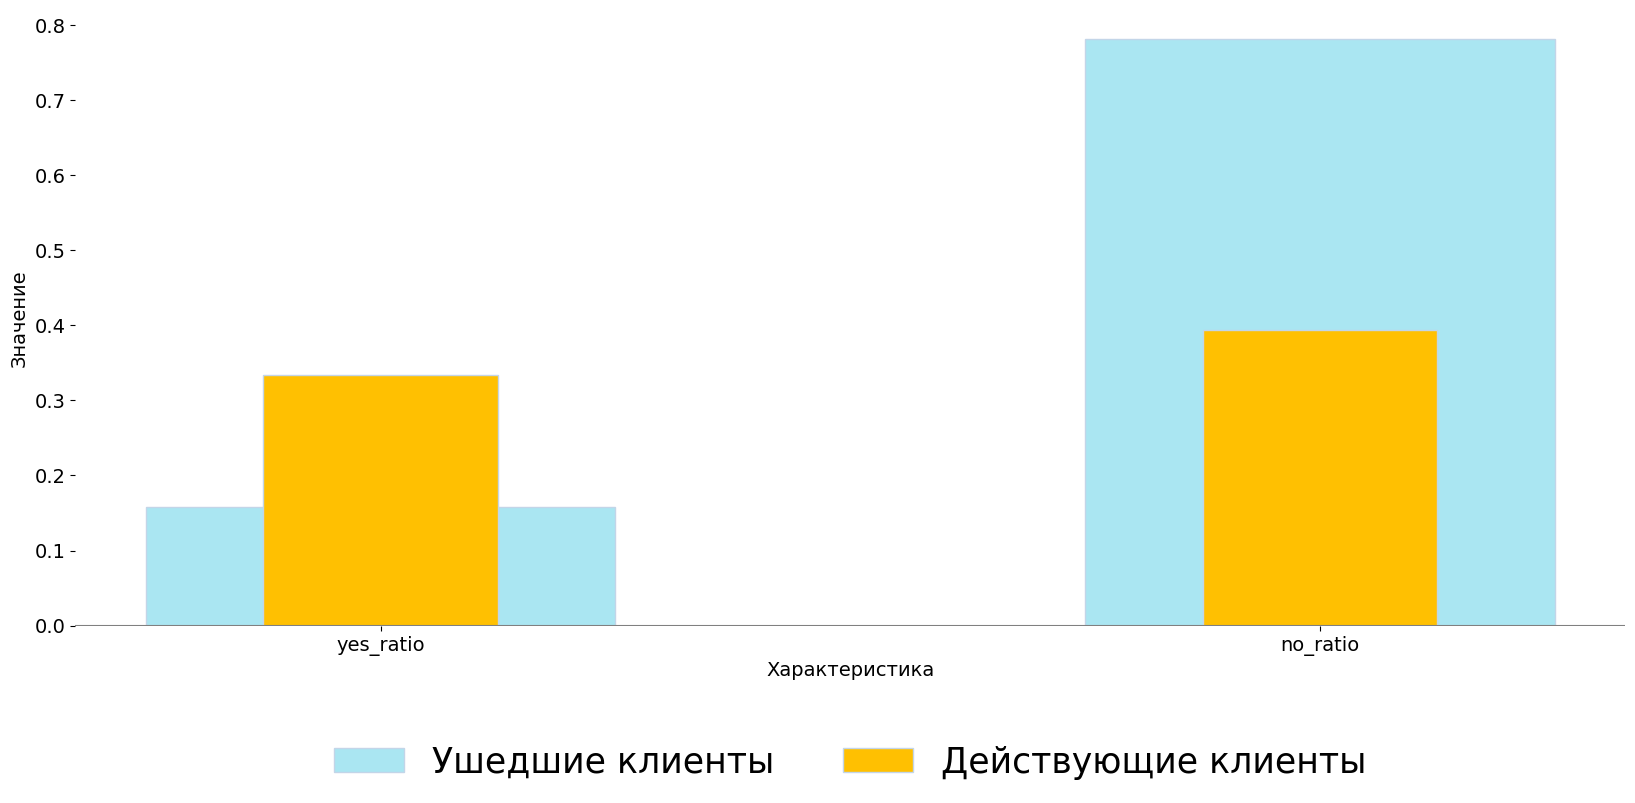

In [58]:
compare_graph(compare_types, 4)

<b>Вывод</b>

Это столбец также стоит включить в признаки для обучения модели, т.к. заметна разница между рассматриваемыми группами клиентов. Пропуски заполнены.

#### Признак OnlineBackup 

In [59]:
col_desc('online_backup')

Описание признака:


count     5517
unique       2
top         No
freq      3088
Name: online_backup, dtype: object

-----------------------------------------------------------
Уникальные значения:


No     3088
Yes    2429
Name: online_backup, dtype: int64

-----------------------------------------------------------
Количество пропусков: 1526
-----------------------------------------------------------


In [60]:
data['online_backup'] = data['online_backup'].fillna('not_using_internet')

In [61]:
query = '''
WITH not_current AS (SELECT
                            'not_current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NOT NULL),

type1_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS yes_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c4 = 'Yes')),
type2_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS no_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c4 = 'No'))
                         

SELECT 
    not_current.client_type,
    not_current.all_count,
    type1_not_current.yes_type,
    type2_not_current.no_type
FROM not_current
JOIN type1_not_current ON not_current.client_type=type1_not_current.client_type
JOIN type2_not_current ON not_current.client_type=type2_not_current.client_type
'''

not_current = pd.read_sql_query(query, con=engine) 

query = '''
WITH current AS (SELECT
                            'current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NULL),

type1_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS yes_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c4 = 'Yes')),
type2_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS no_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c4 = 'No'))
                             

SELECT 
    current.client_type,
    current.all_count,
    type1_current.yes_type,
    type2_current.no_type
FROM current
JOIN type1_current ON current.client_type=type1_current.client_type
JOIN type2_current ON current.client_type=type2_current.client_type
'''

current = pd.read_sql_query(query, con=engine) 

compare_types = pd.concat([not_current, current])
compare_types = compare_types.reset_index(drop=True)
compare_types['yes_ratio'] = compare_types['yes_type']/compare_types['all_count']
compare_types['no_ratio'] = compare_types['no_type']/compare_types['all_count']
display(compare_types)

,client_type,all_count,yes_type,no_type,yes_ratio,no_ratio
0,not_current,1869,523,1233,0.279829,0.659711
1,current,5174,1906,1855,0.368380,0.358523


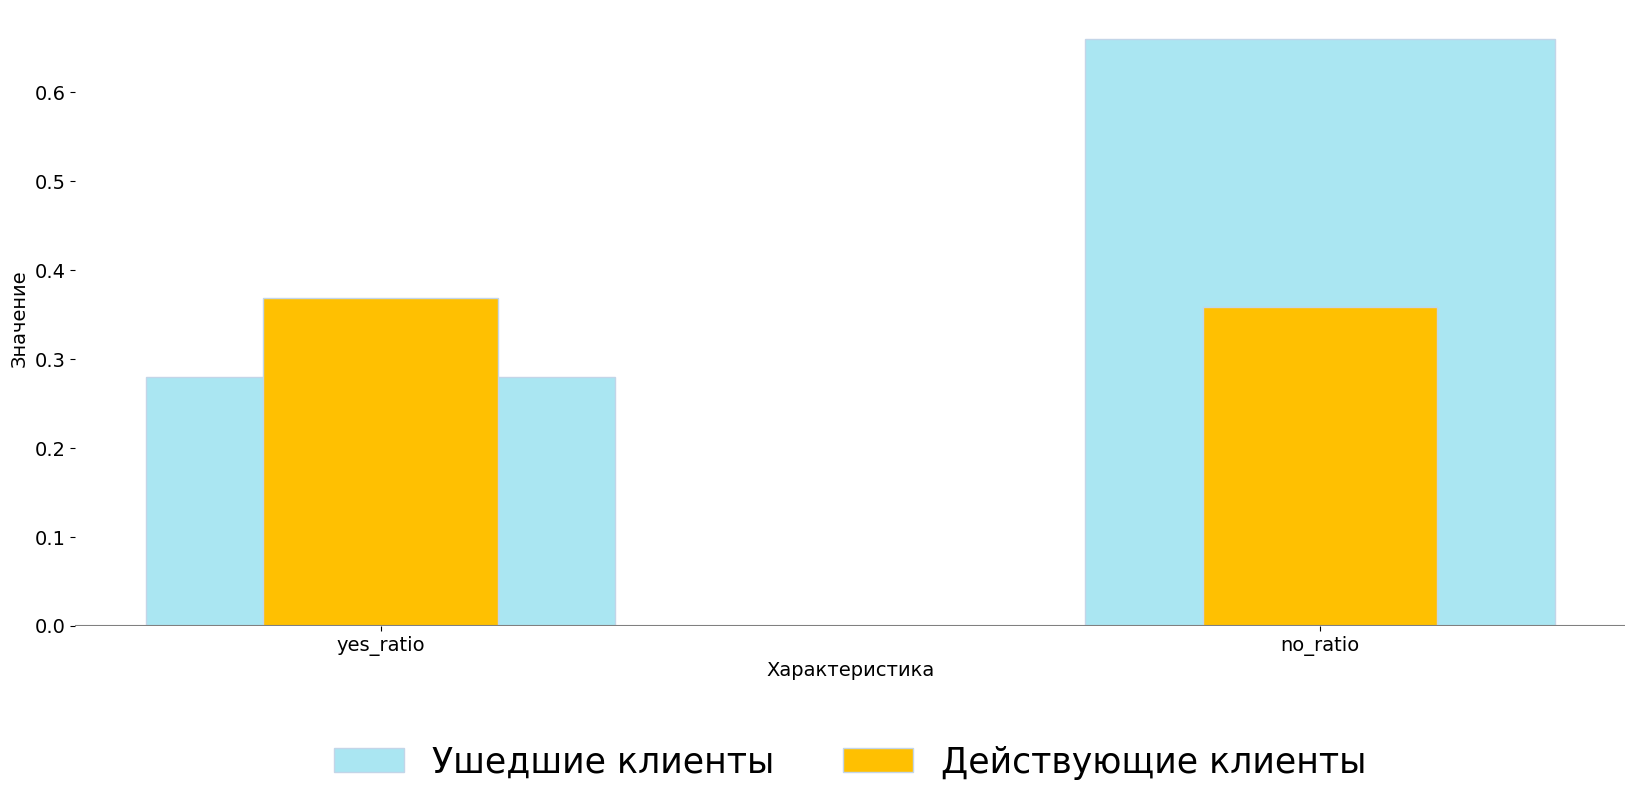

In [62]:
compare_graph(compare_types, 4)

<b>Вывод</b>

Это столбец также стоит включить в признаки для обучения модели, т.к. заметна разница между рассматриваемыми группами клиентов. Пропуски заполнены.

#### Признак DeviceProtection 

In [63]:
col_desc('device_protection')

Описание признака:


count     5517
unique       2
top         No
freq      3095
Name: device_protection, dtype: object

-----------------------------------------------------------
Уникальные значения:


No     3095
Yes    2422
Name: device_protection, dtype: int64

-----------------------------------------------------------
Количество пропусков: 1526
-----------------------------------------------------------


In [64]:
data['device_protection'] = data['device_protection'].fillna('not_using_internet')

In [65]:
query = '''
WITH not_current AS (SELECT
                            'not_current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NOT NULL),

type1_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS yes_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c5 = 'Yes')),
type2_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS no_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c5 = 'No'))
                         

SELECT 
    not_current.client_type,
    not_current.all_count,
    type1_not_current.yes_type,
    type2_not_current.no_type
FROM not_current
JOIN type1_not_current ON not_current.client_type=type1_not_current.client_type
JOIN type2_not_current ON not_current.client_type=type2_not_current.client_type
'''

not_current = pd.read_sql_query(query, con=engine) 

query = '''
WITH current AS (SELECT
                            'current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NULL),

type1_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS yes_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c5 = 'Yes')),
type2_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS no_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c5 = 'No'))
                             

SELECT 
    current.client_type,
    current.all_count,
    type1_current.yes_type,
    type2_current.no_type
FROM current
JOIN type1_current ON current.client_type=type1_current.client_type
JOIN type2_current ON current.client_type=type2_current.client_type
'''

current = pd.read_sql_query(query, con=engine) 

compare_types = pd.concat([not_current, current])
compare_types = compare_types.reset_index(drop=True)
compare_types['yes_ratio'] = compare_types['yes_type']/compare_types['all_count']
compare_types['no_ratio'] = compare_types['no_type']/compare_types['all_count']
display(compare_types)

,client_type,all_count,yes_type,no_type,yes_ratio,no_ratio
0,not_current,1869,545,1211,0.291600,0.647940
1,current,5174,1877,1884,0.362775,0.364128


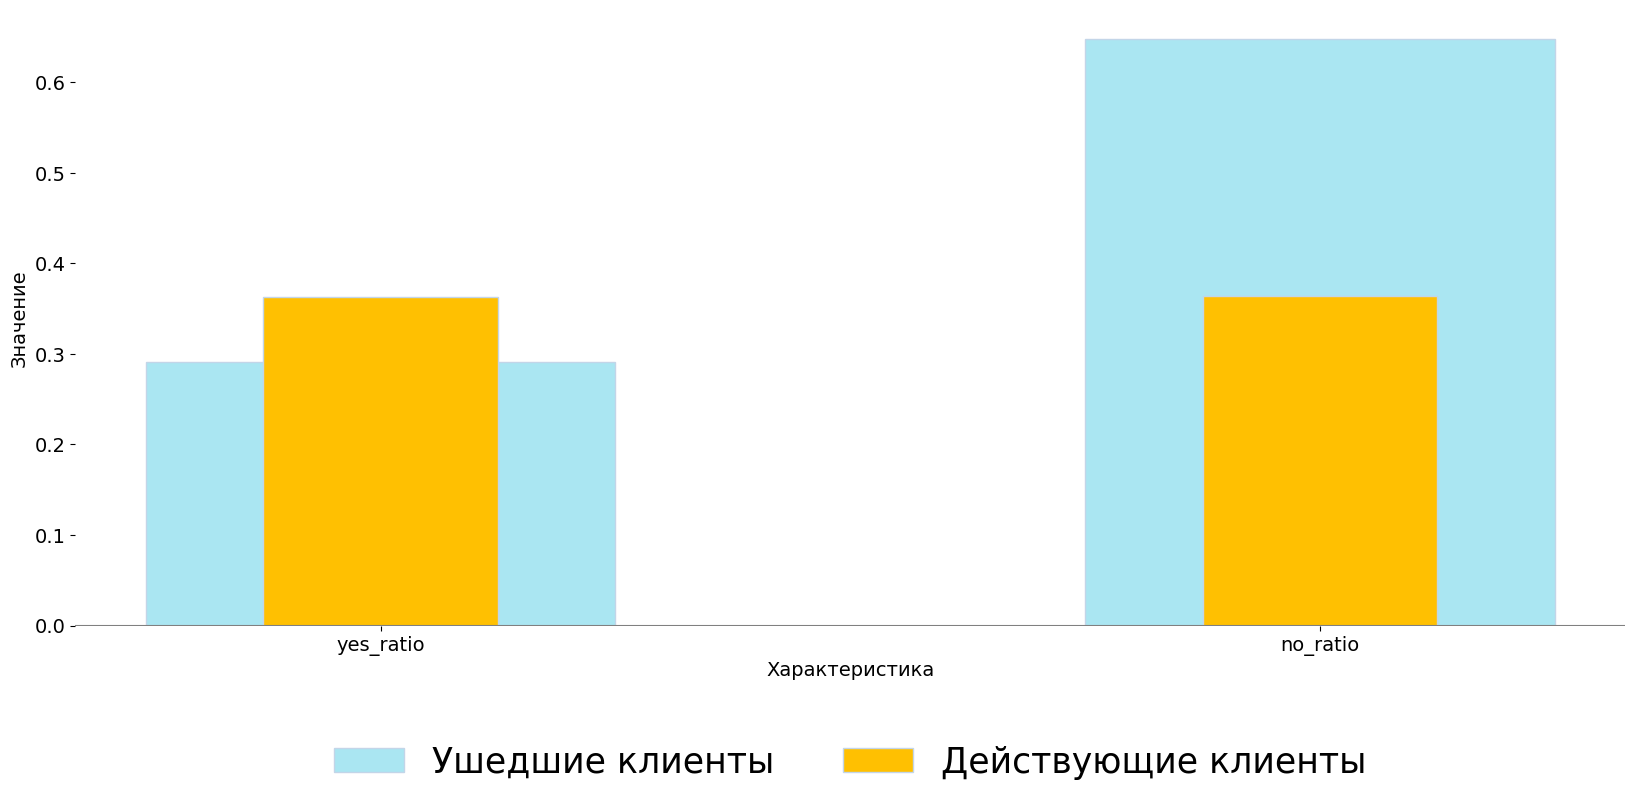

In [66]:
compare_graph(compare_types, 4)

<b>Вывод</b>

Это столбец также стоит включить в признаки для обучения модели, т.к. заметна разница между рассматриваемыми группами клиентов. Пропуски заполнены.

#### Признак TechSupport 

In [67]:
col_desc('tech_support')

Описание признака:


count     5517
unique       2
top         No
freq      3473
Name: tech_support, dtype: object

-----------------------------------------------------------
Уникальные значения:


No     3473
Yes    2044
Name: tech_support, dtype: int64

-----------------------------------------------------------
Количество пропусков: 1526
-----------------------------------------------------------


In [68]:
data['tech_support'] = data['tech_support'].fillna('not_using_internet')

In [69]:
query = '''
WITH not_current AS (SELECT
                            'not_current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NOT NULL),

type1_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS yes_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c6 = 'Yes')),
type2_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS no_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c6 = 'No'))
                         

SELECT 
    not_current.client_type,
    not_current.all_count,
    type1_not_current.yes_type,
    type2_not_current.no_type
FROM not_current
JOIN type1_not_current ON not_current.client_type=type1_not_current.client_type
JOIN type2_not_current ON not_current.client_type=type2_not_current.client_type
'''

not_current = pd.read_sql_query(query, con=engine) 

query = '''
WITH current AS (SELECT
                            'current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NULL),

type1_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS yes_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c6 = 'Yes')),
type2_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS no_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c6 = 'No'))
                             

SELECT 
    current.client_type,
    current.all_count,
    type1_current.yes_type,
    type2_current.no_type
FROM current
JOIN type1_current ON current.client_type=type1_current.client_type
JOIN type2_current ON current.client_type=type2_current.client_type
'''

current = pd.read_sql_query(query, con=engine) 

compare_types = pd.concat([not_current, current])
compare_types = compare_types.reset_index(drop=True)
compare_types['yes_ratio'] = compare_types['yes_type']/compare_types['all_count']
compare_types['no_ratio'] = compare_types['no_type']/compare_types['all_count']
display(compare_types)

,client_type,all_count,yes_type,no_type,yes_ratio,no_ratio
0,not_current,1869,310,1446,0.165864,0.773676
1,current,5174,1734,2027,0.335137,0.391767


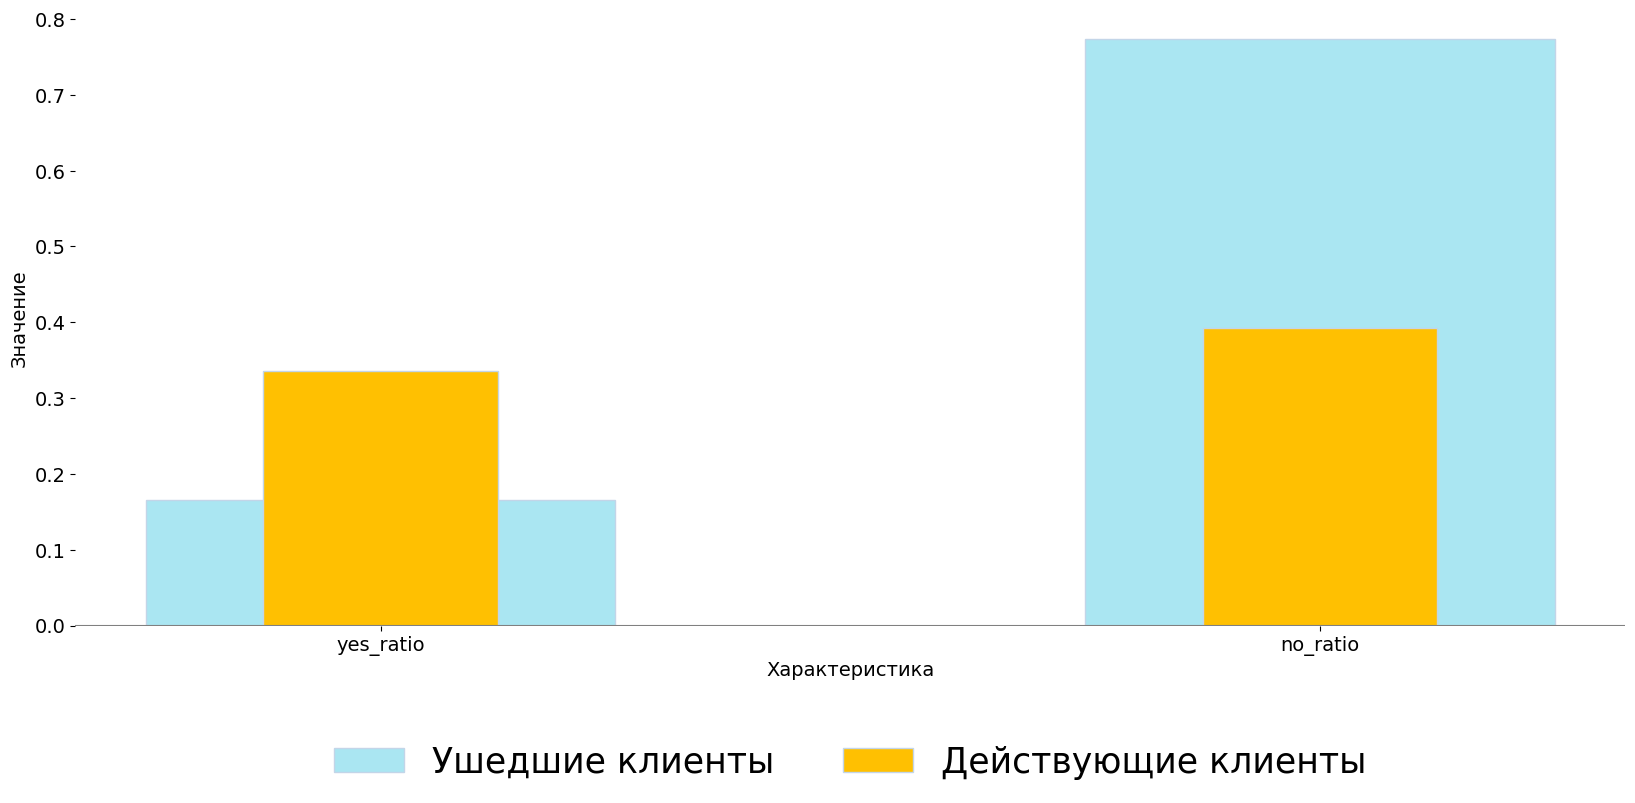

In [70]:
compare_graph(compare_types, 4)

<b>Вывод</b>

Это столбец также стоит включить в признаки для обучения модели, т.к. заметна разница между рассматриваемыми группами клиентов. Пропуски заполнены.

#### Признак StreamingTV 

In [71]:
col_desc('streaming_tv')

Описание признака:


count     5517
unique       2
top         No
freq      2810
Name: streaming_tv, dtype: object

-----------------------------------------------------------
Уникальные значения:


No     2810
Yes    2707
Name: streaming_tv, dtype: int64

-----------------------------------------------------------
Количество пропусков: 1526
-----------------------------------------------------------


In [72]:
data['streaming_tv'] = data['streaming_tv'].fillna('not_using_internet')

In [73]:
query = '''
WITH not_current AS (SELECT
                            'not_current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NOT NULL),

type1_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS yes_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c7 = 'Yes')),
type2_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS no_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c7 = 'No'))
                         

SELECT 
    not_current.client_type,
    not_current.all_count,
    type1_not_current.yes_type,
    type2_not_current.no_type
FROM not_current
JOIN type1_not_current ON not_current.client_type=type1_not_current.client_type
JOIN type2_not_current ON not_current.client_type=type2_not_current.client_type
'''

not_current = pd.read_sql_query(query, con=engine) 

query = '''
WITH current AS (SELECT
                            'current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NULL),

type1_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS yes_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c7 = 'Yes')),
type2_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS no_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c7 = 'No'))
                             

SELECT 
    current.client_type,
    current.all_count,
    type1_current.yes_type,
    type2_current.no_type
FROM current
JOIN type1_current ON current.client_type=type1_current.client_type
JOIN type2_current ON current.client_type=type2_current.client_type
'''

current = pd.read_sql_query(query, con=engine) 

compare_types = pd.concat([not_current, current])
compare_types = compare_types.reset_index(drop=True)
compare_types['yes_ratio'] = compare_types['yes_type']/compare_types['all_count']
compare_types['no_ratio'] = compare_types['no_type']/compare_types['all_count']
display(compare_types)

,client_type,all_count,yes_type,no_type,yes_ratio,no_ratio
0,not_current,1869,814,942,0.435527,0.504013
1,current,5174,1893,1868,0.365868,0.361036


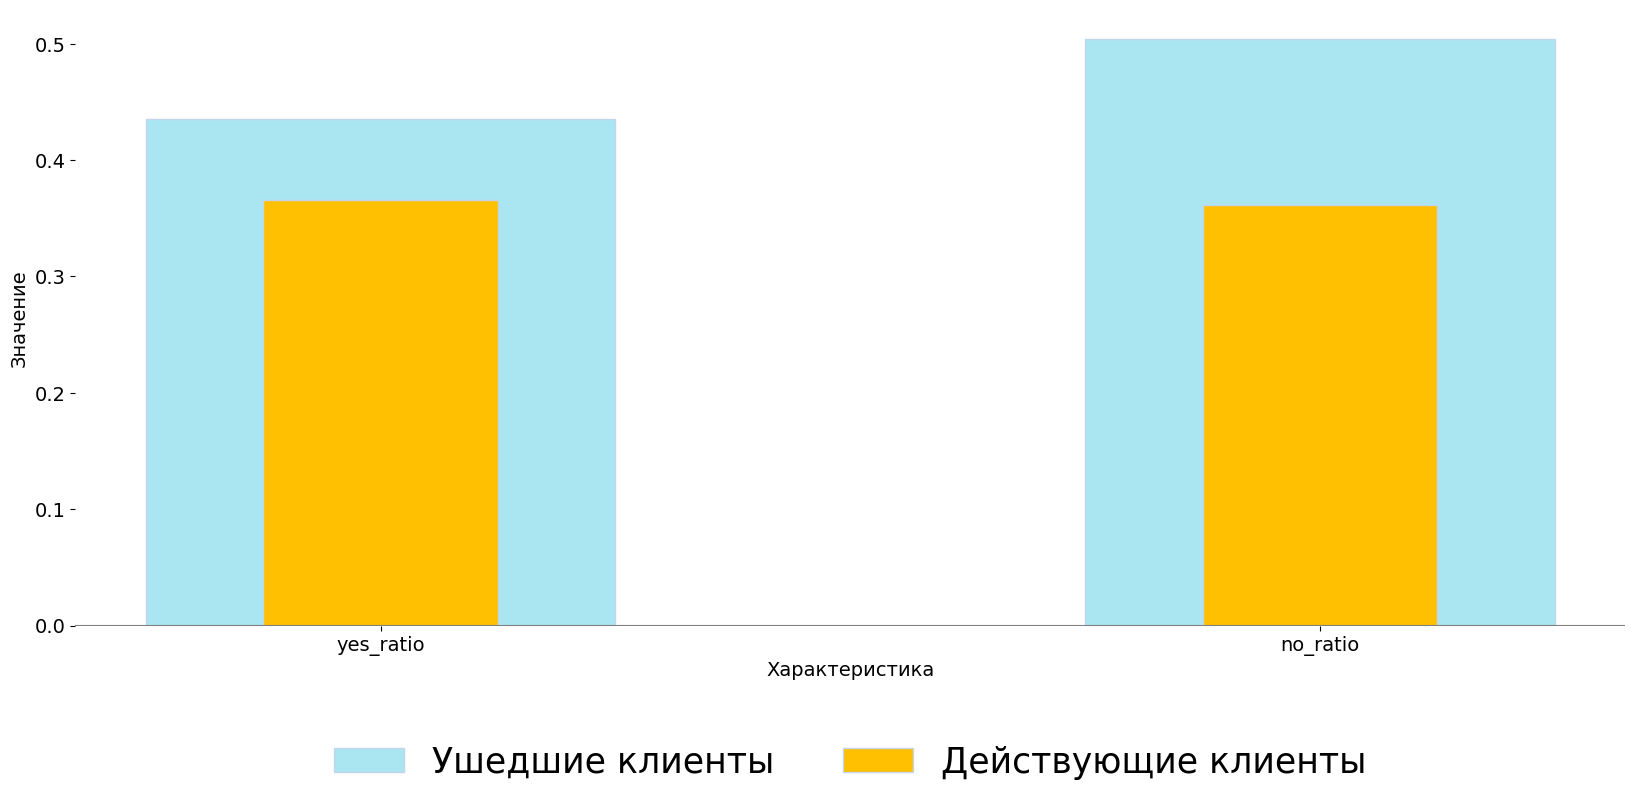

In [74]:
compare_graph(compare_types, 4)

<b>Вывод</b>

Это столбец не имеет смысла включать в признаки для обучения

#### Признак StreamingMovies 

In [75]:
col_desc('streaming_movies')

Описание признака:


count     5517
unique       2
top         No
freq      2785
Name: streaming_movies, dtype: object

-----------------------------------------------------------
Уникальные значения:


No     2785
Yes    2732
Name: streaming_movies, dtype: int64

-----------------------------------------------------------
Количество пропусков: 1526
-----------------------------------------------------------


In [76]:
data['streaming_movies'] = data['streaming_movies'].fillna('not_using_internet')

In [77]:
query = '''
WITH not_current AS (SELECT
                            'not_current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NOT NULL),

type1_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS yes_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c8 = 'Yes')),
type2_not_current AS (SELECT
                    'not_current' AS client_type,
                    COUNT("customerID") AS no_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NOT NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c8 = 'No'))
                         

SELECT 
    not_current.client_type,
    not_current.all_count,
    type1_not_current.yes_type,
    type2_not_current.no_type
FROM not_current
JOIN type1_not_current ON not_current.client_type=type1_not_current.client_type
JOIN type2_not_current ON not_current.client_type=type2_not_current.client_type
'''

not_current = pd.read_sql_query(query, con=engine) 

query = '''
WITH current AS (SELECT
                            'current' AS client_type,
                            COUNT("customerID") AS all_count
                        FROM telecom.contract
                        WHERE contract."EndDate" IS NULL),

type1_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS yes_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c8 = 'Yes')),
type2_current AS (SELECT
                    'current' AS client_type,
                    COUNT("customerID") AS no_type
                FROM telecom.contract
                WHERE contract."EndDate" IS NULL
                AND contract."customerID" IN (SELECT
                                                  c1
                                              FROM telecom.internet
                                              WHERE c8 = 'No'))
                             

SELECT 
    current.client_type,
    current.all_count,
    type1_current.yes_type,
    type2_current.no_type
FROM current
JOIN type1_current ON current.client_type=type1_current.client_type
JOIN type2_current ON current.client_type=type2_current.client_type
'''

current = pd.read_sql_query(query, con=engine) 

compare_types = pd.concat([not_current, current])
compare_types = compare_types.reset_index(drop=True)
compare_types['yes_ratio'] = compare_types['yes_type']/compare_types['all_count']
compare_types['no_ratio'] = compare_types['no_type']/compare_types['all_count']
display(compare_types)

,client_type,all_count,yes_type,no_type,yes_ratio,no_ratio
0,not_current,1869,818,938,0.437667,0.501873
1,current,5174,1914,1847,0.369927,0.356977


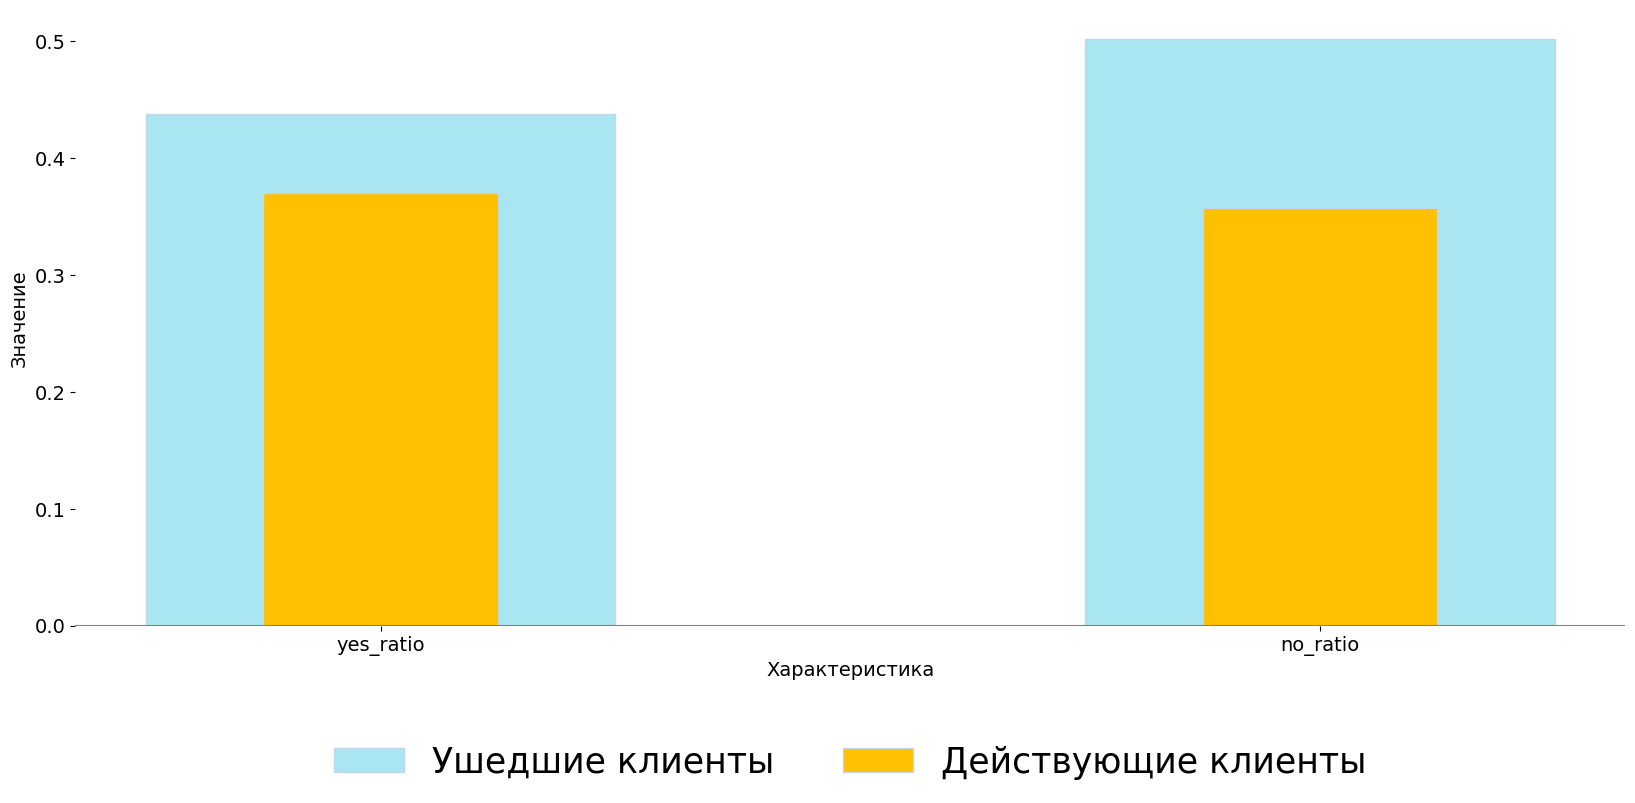

In [78]:
compare_graph(compare_types, 4)

<b>Вывод</b>

Это столбец не имеет смысла включать в признаки для обучения

#### Вывод

Имеем следующие столбцы, которые будут использоваться для обучения модели: 'timedelta', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security',  'online_backup', 'device_protection', 'tech_support'

In [79]:
columns_for_features = ['timedelta', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 
                        'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 
                        'online_backup', 'device_protection', 'tech_support']
features = data[columns_for_features]
target = data['is_not_current']
features.shape

(7043, 13)

## Обучение модели

Найдём лучшую модель прогнозирования оттока. За критерий оценки качества модели по условию необходимо взять метрику ROC-AUC. Значение метрики должно быть не менее 0.78. Для интерпретируемости модели дополнительно выведите значение accuracy каждой модели. Рассмотрите следующие классы моделей:
- решающее дерево,
- бустинги,
- нейронные сети.

In [80]:
for_auc_roc = []
for_acc = []

### Подготовка выборок

In [81]:
categorical = ['type', 'paperless_billing', 'payment_method','senior_citizen', 'partner', 'dependents', 
               'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support']

numeric = ['timedelta', 'monthly_charges']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=123)

print('Размер выборки признаков для обучения:', features_train.shape)
print('Размер выборки целевого признака для обучения:', target_train.shape)
print('Размер выборки признаков для теста:', features_test.shape)
print('Размер выборки целевого признака для теста:', target_test.shape)

Размер выборки признаков для обучения: (5634, 13)
Размер выборки целевого признака для обучения: (5634,)
Размер выборки признаков для теста: (1409, 13)
Размер выборки целевого признака для теста: (1409,)


In [82]:
col_transformer = ColumnTransformer(
    transformers=[('ss', StandardScaler(), numeric),
                  ('ohe', OneHotEncoder(drop='first'), categorical)], 
    remainder='passthrough', n_jobs=-1,  sparse_threshold=0)

### DecisionTreeClassifier

In [83]:
dtc_pipeline = Pipeline(
    [
        ("transformer", col_transformer),
        ("dtc", DecisionTreeClassifier())
    ]
)

In [84]:
params = {
    'dtc__max_depth': range(10, 121, 10),
    'dtc__class_weight':[None, 'balanced']
}

grid_dt = GridSearchCV(dtc_pipeline, params, n_jobs=-1, scoring = 'roc_auc', verbose=3, cv=3)
grid_dt.fit(features_train, target_train)

print('Средняя оценка качества модели дерева решений ROC-AUC:', grid_dt.best_score_)
for_auc_roc.append(grid_dt.best_score_)

preds = grid_dt.predict(features_train)
acc = accuracy_score(target_train, preds)
print('Accuracy:', acc)
for_acc.append(acc)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Средняя оценка качества модели дерева решений ROC-AUC: 0.7491894215639922
Accuracy: 0.8368832090876819


<b>Вывод</b>

Стандартная модель дерева решений выдаёт нужное значение метрики ROC-AUC > 0.78

### LGBMClassifier

In [85]:
lgb_pipeline = Pipeline(
    [
        ("transformer", col_transformer),
        ("lgb", LGBMClassifier())
    ]
)

In [86]:
params = {
    'lgb__max_depth': range(10, 121, 10),
    'lgb__n_estimators': range(10, 121, 10),
    'lgb__class_weight':[None, 'balanced']
}

grid_lgb = GridSearchCV(lgb_pipeline, params, n_jobs=-1, scoring = 'roc_auc', verbose=3, cv=3)
grid_lgb.fit(features_train, target_train)

print('Средняя оценка качества модели градиентного бустинга ROC-AUC:', grid_lgb.best_score_)
for_auc_roc.append(grid_lgb.best_score_)

preds = grid_lgb.predict(features_train)
acc = accuracy_score(target_train, preds)
print('Accuracy:', acc)
for_acc.append(acc)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Средняя оценка качества модели градиентного бустинга ROC-AUC: 0.8239246101939174
Accuracy: 0.8106141285055023


<b>Вывод</b>

Значение контрольной метрики ROC-AUC у модели градиентного бустинга лучше, чем у модели дерева решений.

### Полносвязная нейронная сеть

In [87]:
col_transformer.fit(features_train)

features_train_transformed = col_transformer.transform(features_train)
features_test_transformed = col_transformer.transform(features_test)

X_train = torch.FloatTensor(features_train_transformed)
Y_train = torch.FloatTensor(target_train.values)
X_test = torch.FloatTensor(features_test_transformed)
Y_test = torch.FloatTensor(target_test.values)

In [88]:
class Model_improve(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, 
                 dropout_1, dropout_2):
        super(Model_improve, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.dp1 = nn.Dropout(p=dropout_1)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.dp2 = nn.Dropout(p=dropout_2)
        self.act2 = nn.ReLU()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.dp2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)
            
        return x

In [89]:
batch_size = 4
lr = 1e-3
patience = 3
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True)

skorch_regressor = NeuralNetClassifier(module=Model_improve, 
                                      device='cpu',  
                                      verbose=0,
                                      batch_size=batch_size,
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=100, 
                                      lr=lr,
                                      train_split=ValidSplit(cv=0.2),
                                      criterion=nn.BCELoss,
                                      callbacks=[
                                          ('val_rmse', EpochScoring(scoring=roc_auc_scorer, lower_is_better=False, name='roc_auc')),
                                          ('estoper', EarlyStopping(monitor='roc_auc', lower_is_better=False, patience=patience, threshold=0.01)),
                                      ],
                                     )

In [90]:
n_in_neurons = X_train.shape[1]
n_out_neurons = 1

In [91]:
params = {'module__dropout_1': [0.3, 0.5, 0.7],
          'module__n_in_neurons': [n_in_neurons],
          'module__n_hidden_neurons_1': [15, 25, 45],
          'module__n_hidden_neurons_2': [15, 25, 45],
          'module__n_out_neurons': [n_out_neurons],
          'module__dropout_2': [0.3, 0.5, 0.7],
          'batch_size': [12]
         }

In [92]:
grid = GridSearchCV(skorch_regressor, params, cv=3, scoring="roc_auc", verbose=1) 
grid.fit(X_train, Y_train.reshape(-1, 1))

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.Model_improve'>,
),
             param_grid={'batch_size': [12],
                         'module__dropout_1': [0.3, 0.5, 0.7],
                         'module__dropout_2': [0.3, 0.5, 0.7],
                         'module__n_hidden_neurons_1': [15, 25, 45],
                         'module__n_hidden_neurons_2': [15, 25, 45],
                         'module__n_in_neurons': [21],
                         'module__n_out_neurons': [1]},
             scoring='roc_auc', verbose=1)

In [93]:
print('Средняя оценка качества модели нейронной сети ROC-AUC:', grid.best_score_)
for_auc_roc.append(grid.best_score_)


preds = grid.predict(X_train).flatten()
acc = accuracy_score(Y_train, preds)
print('Accuracy:', acc)
for_acc.append(acc)

Средняя оценка качества модели нейронной сети ROC-AUC: 0.8258305860762927
Accuracy: 0.7816826411075612


<b>Вывод</b>

Модель полносвязной нейронной сети с выбранной архитектурой показывает значение метрики ROC-AUC выше чем модели дерева решений и градиентного бустинга

### Сравнение моделей

In [94]:
compare_models = pd.DataFrame()
models_list = ['DecisionTreeClassifier', 'LGBMClassifier', 'NeuralNetClassifier']

compare_models['model'] = models_list
compare_models['ROC-AUC train'] = for_auc_roc
compare_models['Accuracy train'] = for_acc

compare_models = compare_models.sort_values('ROC-AUC train', ascending=False)

display(compare_models)

,model,ROC-AUC train,Accuracy train
2,NeuralNetClassifier,0.825831,0.781683
1,LGBMClassifier,0.823925,0.810614
0,DecisionTreeClassifier,0.749189,0.836883


## Тестирование модели

In [95]:
preds_test = grid_lgb.predict_proba(features_test)

print('Значение метрики ROC-AUC для лучшей модели равно:',  roc_auc_score(target_test, preds_test[:, 1]))

Значение метрики ROC-AUC для лучшей модели равно: 0.8240371336504526


<b>Нужное значение контрольной метрики на тестовой выборке достигнуто</b>

### Графический анализ «Матрица ошибок»

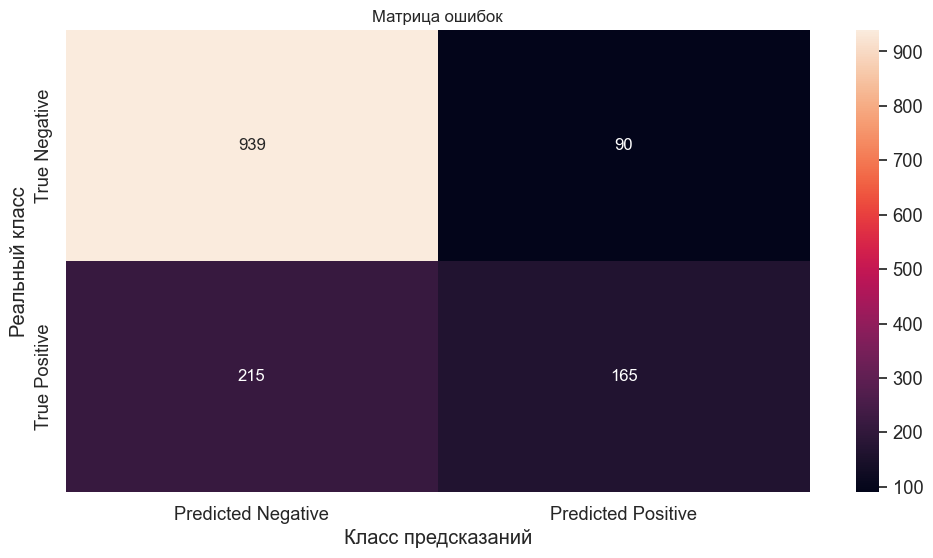

In [96]:


conf_matrix = confusion_matrix(target_test, np.round(preds_test[:, 1]))

df_conf_matrix = pd.DataFrame(conf_matrix, index=['True Negative', 'True Positive'],
                 columns=['Predicted Negative', 'Predicted Positive'])

sns.set(font_scale=1.2)
plt.figure(figsize=(12,6))
    
sns.heatmap(conf_matrix, annot=True, fmt='g' ,xticklabels=df_conf_matrix.columns, yticklabels=df_conf_matrix.index, annot_kws={"size": 12})
plt.title("Матрица ошибок", size=12)
plt.xlabel('Класс предсказаний')
plt.ylabel('Реальный класс');

In [97]:
TP = conf_matrix[0][0]
TN = conf_matrix[1][1]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]
total = conf_matrix[0][0]+conf_matrix[1][1]+conf_matrix[0][1]+conf_matrix[1][0]

print('Всего предсказаний:',total)
print(f'Правильно классифицированные: {np.round((TP+TN)/total*100)}%')
print(f'Правильно классифицированное намерение клиента уйти: {np.round(TP/(TP+FN)*100)}%')
print(f'Правильно классифицированое отсутствие намерения клиента уйти: {np.round(TN/(TN+FP)*100)}%')
print(f'Прогнозируемая намерение клиента уйти, соответствующая действительности: {np.round(TP/(TP+FP)*100)}%')
print(f'Прогнозируемое отсутствие намерения клиента уйти, которого так же на самом деле нет: {np.round(TN/(TN+FN)*100)}%')

Всего предсказаний: 1409
Правильно классифицированные: 78.0%
Правильно классифицированное намерение клиента уйти: 81.0%
Правильно классифицированое отсутствие намерения клиента уйти: 65.0%
Прогнозируемая намерение клиента уйти, соответствующая действительности: 91.0%
Прогнозируемое отсутствие намерения клиента уйти, которого так же на самом деле нет: 43.0%


### График важности основных факторов

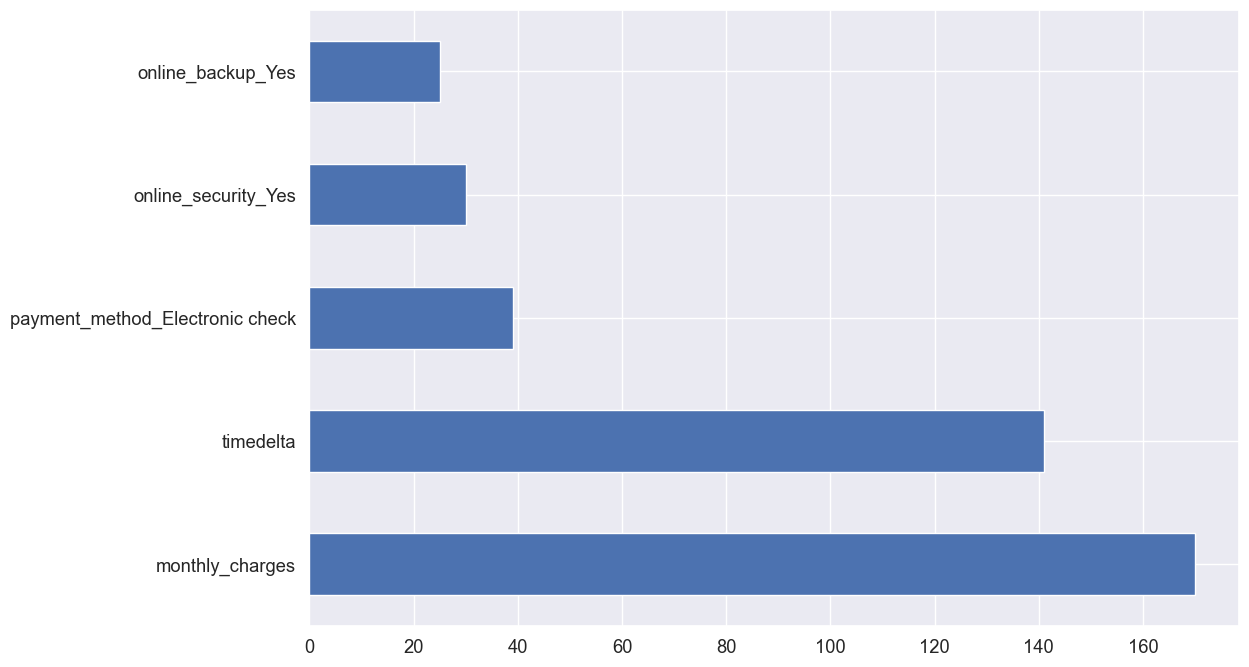

In [98]:
features_train_ohe = pd.get_dummies(features_train, columns = categorical, drop_first=True)

plt.figure(figsize=(12, 8))
feat_importances_dt = pd.Series((grid_lgb.best_estimator_[1].feature_importances_), index=features_train_ohe.columns)
feat_importances_dt.nlargest(5).plot(kind='barh')
plt.show()

<b>Вывод</b>

Наиболее важный фактор для моделей - насколько давно клиент заключил договор с компанией. Следующие по важности факторы идут: ежемесячные расходы, тип оплаты равный одному году, метод оплаты и наличие блокировки небезопасных сайтов.

### Анализ наиболее важных факторов

#### timedelta

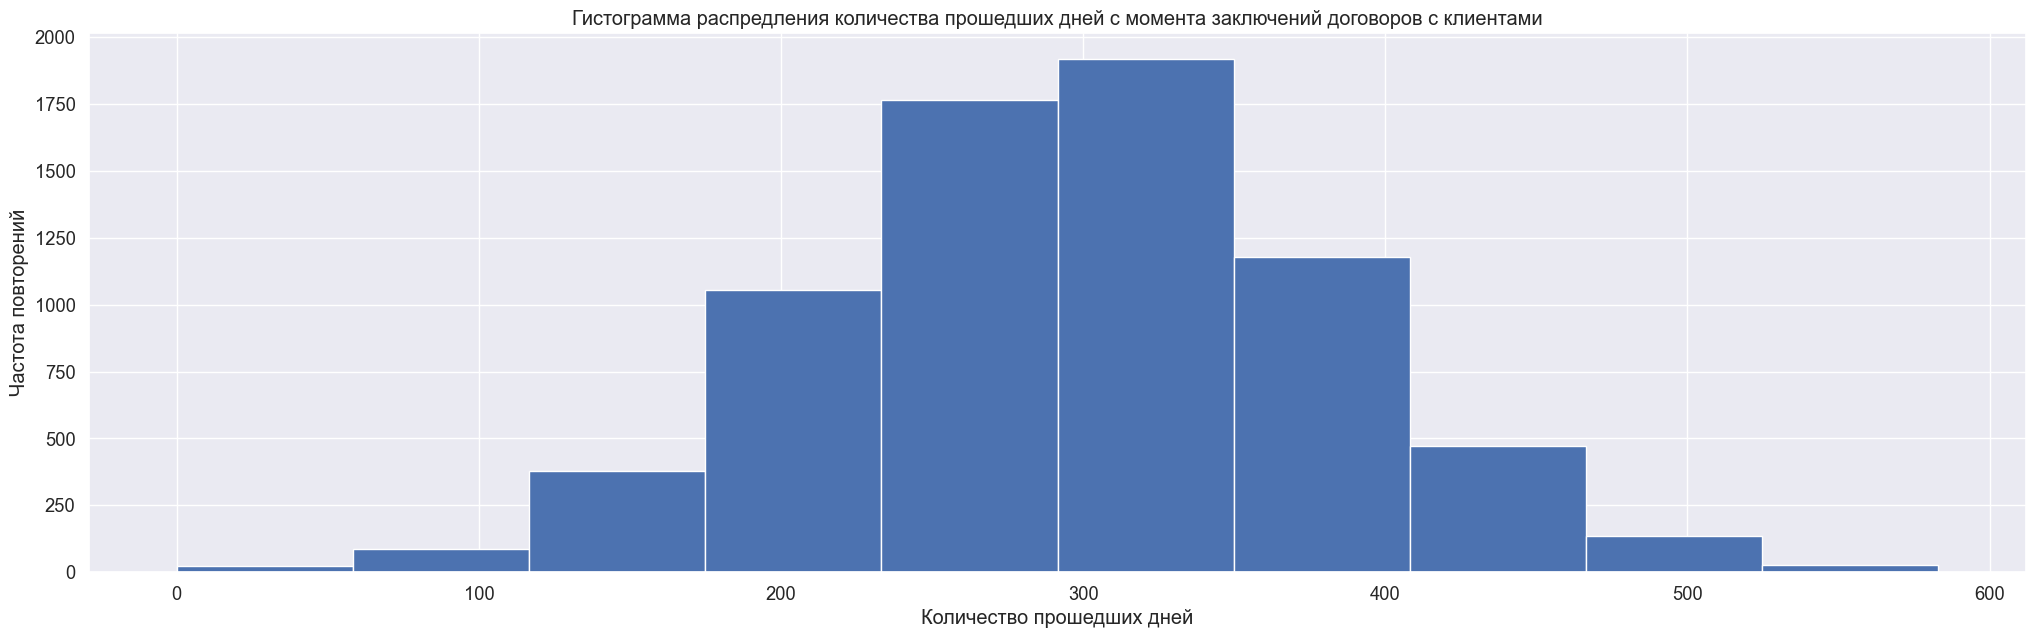

In [99]:
data['timedelta'].hist()
plt.title('Гистограмма распредления количества прошедших дней с момента заключений договоров с клиентами')
plt.xlabel('Количество прошедших дней')
plt.ylabel('Частота повторений')
plt.show()

Судя по тому, что график имеет пик в районе 300 дней и что правая часть от пика явно перешивает левую, можно сказать, что оператор связи с каждым месяцем заключает всё меньше новых контрактов. В таком случае, стоит заметить, что привлечение новых клиентов может быть более приоритетной задачей, чем уменьшение оттока клиентов путём предложения клиентам специальных условий.

#### monthly_charges

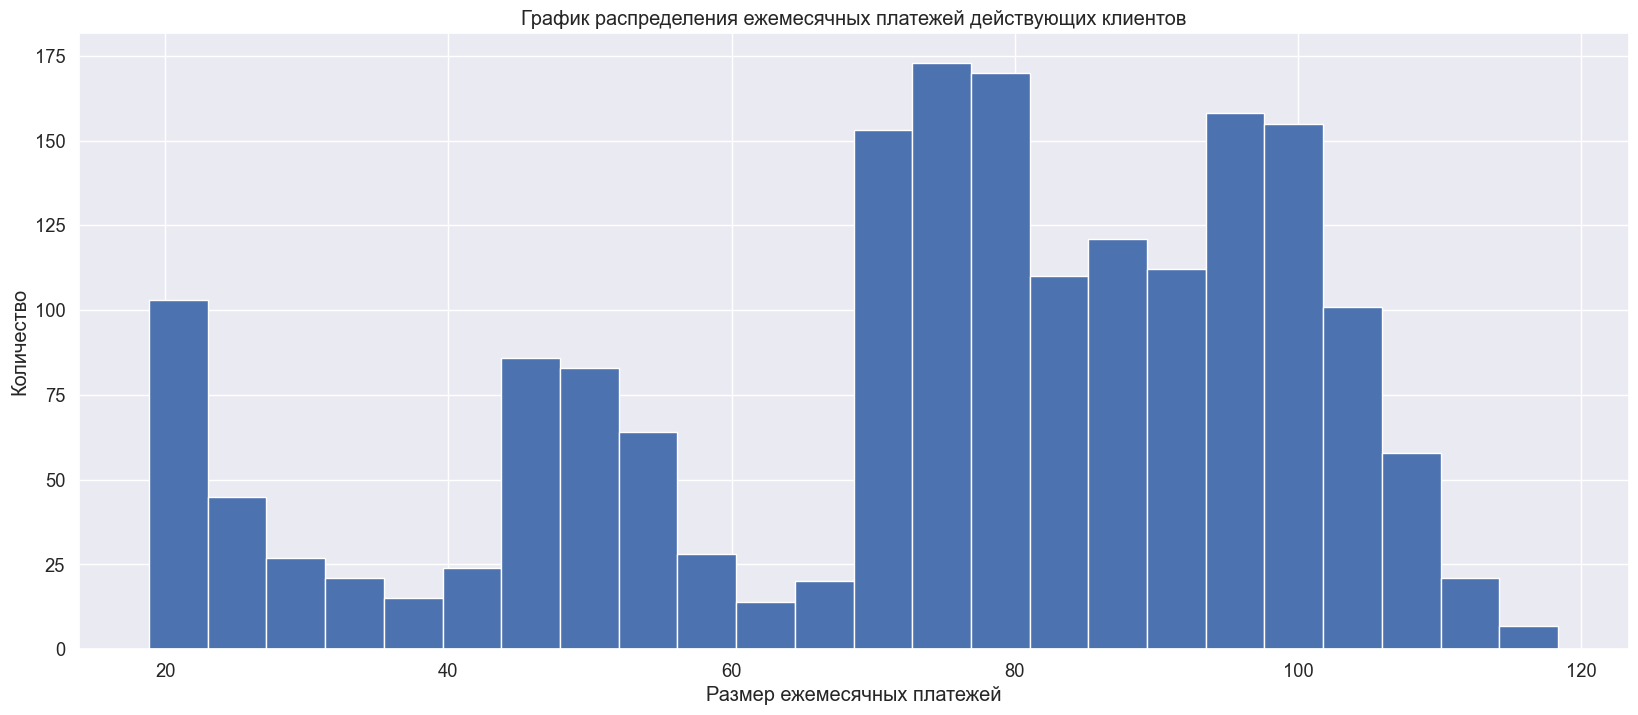

In [100]:
query = '''
SELECT
    "MonthlyCharges"
FROM telecom.contract
WHERE contract."EndDate" IS NOT NULL
'''

current_clients = pd.read_sql_query(query, con=engine) 

plt.figure(figsize=(20, 8))
plt.hist(current_clients['MonthlyCharges'], bins=24)
plt.gca().set(title='График распределения ежемесячных платежей действующих клиентов', ylabel='Количество', xlabel='Размер ежемесячных платежей')
plt.show()

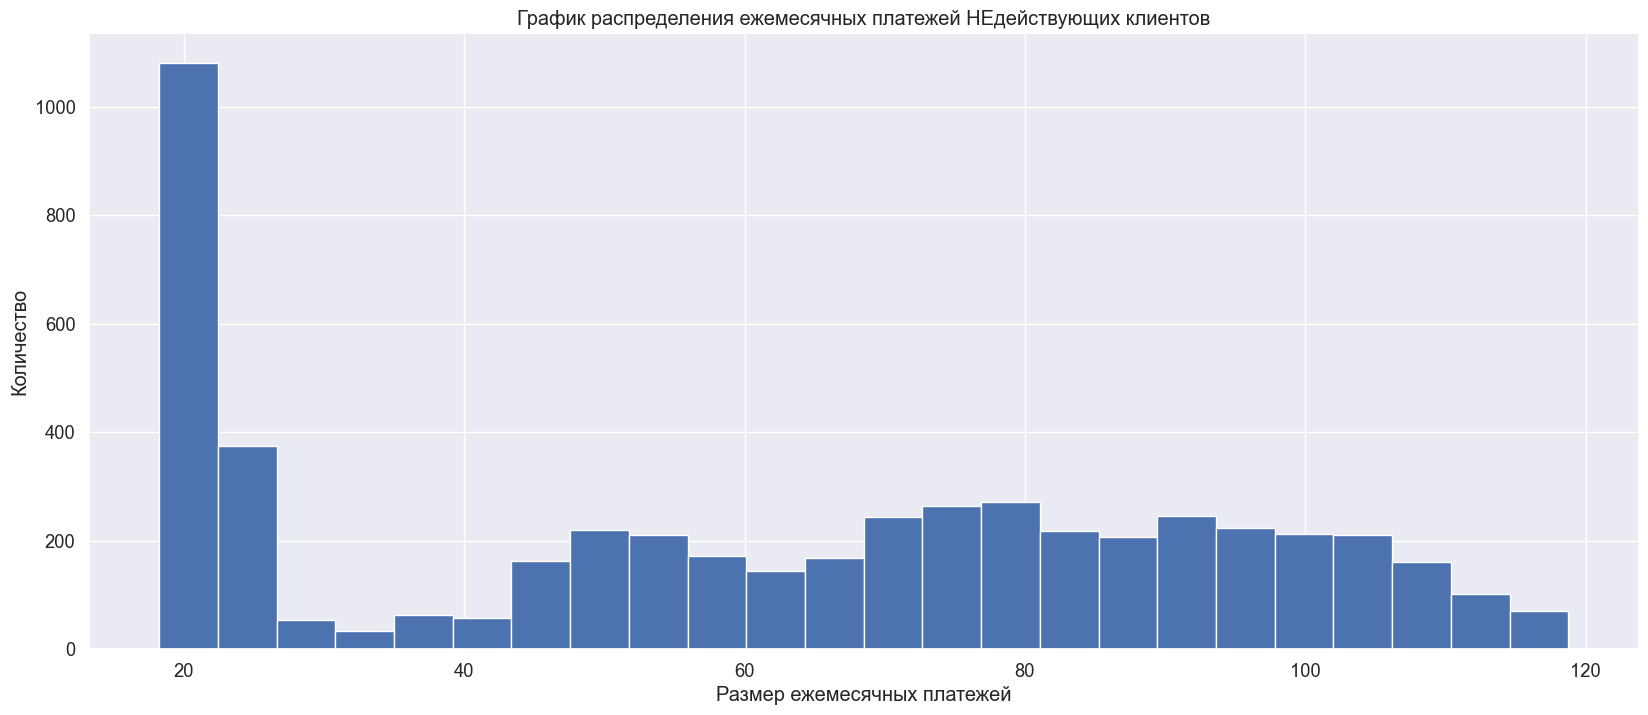

In [101]:
query = '''
SELECT
    "MonthlyCharges"
FROM telecom.contract
WHERE contract."EndDate" IS NULL
'''

not_current_clients = pd.read_sql_query(query, con=engine) 

plt.figure(figsize=(20, 8))
plt.hist(not_current_clients['MonthlyCharges'], bins=24)
plt.gca().set(title='График распределения ежемесячных платежей НЕдействующих клиентов', ylabel='Количество', xlabel='Размер ежемесячных платежей')
plt.show()

Для уменьшения оттока, оператору связи стоит обратить внимание на клиентов, чей ежемесячный платёж меньше 30 - среди таких клиентов наибольшее число уже ушедших клиентов.

## Выводы

- Данные исследованы, выделены признаки для обучения и целевой признак.
- Обучены три модели: модель дерева решений, модель градиентного бустинга, модель полносвязной нейронной сети со своей архитектурой. Среди моделей на обучающей выборке лучше всего показала себя модель нейронной сети, однако на тестовой выборке она даёт низкое значение, предположительно, из-за переобучения. Модель градиентного бустинга показала себя стабильнее и выдала значение контрольной метрики ROC-AUC больше 0.78
- Наиболее важными факторами для модели стали количество прошедших дней с момента заключений договоров с клиентами и размер ежемесячных платежей
- Рекомендации оператору связи: для уменьшения оттока стоит обратить внимание на клиентов, чей ежемесячный платёж меньше 30 - среди таких клиентов наибольшее число уже ушедших клиентов; оператор связи с каждым месяцем заключает всё меньше новых контрактов, поэтому, стоит заметить, что привлечение новых клиентов может быть более приоритетной задачей, чем уменьшение оттока клиентов путём предложения клиентам специальных условий.